# Load in the data set fruits:

In [ ]:
from google.colab import drive

# Mount Google Drive to access files and folders
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Thesis code/healthy_scab_FDs/'
train_dir = '/content/drive/MyDrive/Thesis code/healthy_scab_FDs/training/'
val_dir = '/content/drive/MyDrive/Thesis code/healthy_scab_FDs/validation/'
train_val_dir = '/content/drive/MyDrive/Thesis code/healthy_scab_FDs/train_val'
test_dir = '/content/drive/MyDrive/Thesis code/healthy_scab_FDs/test/'

# Preprocess the images and apply data augmentation to the training set:

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

def train_val_test_generators(TRAINING_DIR, VALIDATION_DIR, TRAIN_VAL_DIR, TESTING_DIR):

  # preprocessing training images (including data augmentation)
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(224, 224))
  
  # preprocessing training images
  validation_datagen = ImageDataGenerator(rescale = 1/255)

  validation_generator = validation_datagen.flow_from_directory(directory= VALIDATION_DIR,
                                                                shuffle = False,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(224, 224))
  
  # preprocessing train_val images (including data augmentation)
  train_val_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  train_val_generator = train_val_datagen.flow_from_directory(directory=TRAIN_VAL_DIR, 
                                                              shuffle=True,
                                                              batch_size=32,
                                                              class_mode='binary',
                                                              target_size=(224, 224))
  
  # preprocessing train_val images (including data augmentation)
  testing_datagen = ImageDataGenerator(rescale = 1/255)

  testing_generator = testing_datagen.flow_from_directory(directory= TESTING_DIR,
                                                          shuffle=False,
                                                          batch_size=32,
                                                          class_mode='binary',
                                                          target_size=(224, 224))

  return train_generator, validation_generator, train_val_generator, testing_generator

# Download/import libraries

## Install Optuna (library for the tuning of hyperparameters)

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.5 MB/s eta 0:00:00


## Importing the necessary libraries (such as Optuna and Tensorflow/Keras)

In [ ]:
import optuna
import tensorflow as tf
import urllib
import warnings

from tensorflow.keras import Model
from keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop
from keras.backend import clear_session

import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

import tensorflow as tf
import numpy as np

np.random.seed(42)
tf.random.set_seed(42)

# Basic CNN model:

## Perform hyperparameter tuning on the Basic CNN model.

In [ ]:
def hp_basic_cnn(trail):

  clear_session()

  # preprocess data
  train, val, train_val, test = train_val_test_generators(train_dir, val_dir, train_val_dir, test_dir)

  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train.classes), y = train.classes)
  class_weights = {i : class_weights[i] for i in range(2)}

  # build model
  hidden_layers = trail.suggest_int('hidden_layers', 1, 2)
  first_neuron = trail.suggest_categorical('first_neuron', [128, 256, 512])
  drop_out = trail.suggest_categorical('drop_out', [0, 0.3, 0.5])

  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2), 
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten() ])
  
  for i in range(hidden_layers):
    model.add(Dense(first_neuron, activation='relu'))
    model.add(Dropout(drop_out))

  model.add(Dense(1, activation='sigmoid'))

  # compile/train model
  optimizer_name = trail.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'AdamW'])
  learning_rate = trail.suggest_float('lr', 1e-5, 1e-2, log=True)

  if optimizer_name == 'Adam':
      optimizer = Adam(learning_rate=learning_rate)
  elif optimizer_name == 'RMSprop':
      optimizer = RMSprop(learning_rate=learning_rate)
  elif optimizer_name == 'AdamW':
      optimizer = AdamW(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,
                loss = 'binary_crossentropy', 
                metrics = ['accuracy'])#, Recall(), Precision()
  
  early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  model.fit(train, validation_data=val, class_weight=class_weights, epochs = 100, callbacks=[early_stop], 
            max_queue_size=40, workers=4, use_multiprocessing=True)
  
  # evaluate macro f1 score
  y_pred_val = model.predict(val)
  y_pred_val = np.round(y_pred_val)

  f1score_macro = f1_score(val.labels, y_pred_val, average = 'macro')
  print(f1score_macro)
  
  return f1score_macro


if __name__ == "__main__":
    warnings.warn(
        "Recent Keras release (2.4.0) simply redirects all APIs "
        "in the standalone keras package to point to tf.keras. "
        "There is now only one Keras: tf.keras. "
        "There may be some breaking changes for some workflows by upgrading to keras 2.4.0. "
        "Test before upgrading. "
        "REF:https://github.com/keras-team/keras/releases/tag/2.4.0"
    )
    study = optuna.create_study(direction="maximize")
    study.optimize(hp_basic_cnn, n_trials=10)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

<ipython-input-14-ce5c7e18b151>:65: UserWarning: Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  warnings.warn(
[I 2023-05-14 10:37:33,541] A new study created in memory with name: no-name-c52381d5-9c94-4b8d-ab80-4bebbbe0be98


Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 86s 14s/step - loss: 41.5952 - accuracy: 0.5955 - val_loss: 3.6999 - val_accuracy: 0.3051
Epoch 2/100
6/6 [==============================] - 28s 4s/step - loss: 1.0322 - accuracy: 0.3315 - val_loss: 0.7128 - val_accuracy: 0.3390
Epoch 3/100
6/6 [==============================] - 27s 4s/step - loss: 0.6765 - accuracy: 0.4663 - val_loss: 0.6728 - val_accuracy: 0.6441
Epoch 4/100
6/6 [==============================] - 28s 4s/step - loss: 0.7015 - accuracy: 0.5562 - val_loss: 0.7256 - val_accuracy: 0.3051
Epoch 5/100
6/6 [==============================] - 27s 4s/step - loss: 0.6991 - accuracy: 0.4157 - val_loss: 0.6962 - val_accuracy: 0.3051
Epoch 6/100
6/6 [==============================] - 23s 3s/step - loss: 0.6947 - accuracy: 0.5169 - val_loss: 0.6897 - val_accuracy: 0.6949
Ep

[I 2023-05-14 10:42:50,701] Trial 0 finished with value: 0.43295194508009155 and parameters: {'hidden_layers': 1, 'first_neuron': 512, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 0.003970461444480544}. Best is trial 0 with value: 0.43295194508009155.


0.43295194508009155
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 34s 6s/step - loss: 21.1999 - accuracy: 0.5056 - val_loss: 0.6578 - val_accuracy: 0.6949
Epoch 2/100
6/6 [==============================] - 29s 4s/step - loss: 0.7112 - accuracy: 0.5449 - val_loss: 0.6957 - val_accuracy: 0.3898
Epoch 3/100
6/6 [==============================] - 27s 4s/step - loss: 0.6706 - accuracy: 0.5112 - val_loss: 0.6269 - val_accuracy: 0.6780
Epoch 4/100
6/6 [==============================] - 27s 4s/step - loss: 0.7868 - accuracy: 0.5337 - val_loss: 0.7042 - val_accuracy: 0.3051
Epoch 5/100
6/6 [==============================] - 27s 5s/step - loss: 0.7701 - accuracy: 0.5674 - val_loss: 0.7089 - val_accuracy: 0.3051
Epoch 6/100
6/6 [==============================] - 28s 5s/step - loss: 0.7288 - accuracy: 0.6180 - val_loss: 0.7052 - val_

[I 2023-05-14 10:47:13,517] Trial 1 finished with value: 0.40404040404040403 and parameters: {'hidden_layers': 2, 'first_neuron': 128, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 0.004900260184287499}. Best is trial 0 with value: 0.43295194508009155.


0.40404040404040403
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 35s 5s/step - loss: 0.6927 - accuracy: 0.5843 - val_loss: 0.6652 - val_accuracy: 0.7119
Epoch 2/100
6/6 [==============================] - 29s 4s/step - loss: 0.6820 - accuracy: 0.7022 - val_loss: 0.7034 - val_accuracy: 0.3390
Epoch 3/100
6/6 [==============================] - 27s 5s/step - loss: 0.6746 - accuracy: 0.3596 - val_loss: 0.6993 - val_accuracy: 0.4746
Epoch 4/100
6/6 [==============================] - 28s 4s/step - loss: 0.6614 - accuracy: 0.7191 - val_loss: 0.6652 - val_accuracy: 0.6441
Epoch 5/100
6/6 [==============================] - 29s 4s/step - loss: 0.6461 - accuracy: 0.6292 - val_loss: 0.7269 - val_accuracy: 0.4237
Epoch 6/100
6/6 [==============================] - 29s 5s/step - loss: 0.6466 - accuracy: 0.6292 - val_loss: 0.6637 - val_a

[I 2023-05-14 10:53:06,293] Trial 2 finished with value: 0.6141135972461274 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 1.3674709160089072e-05}. Best is trial 2 with value: 0.6141135972461274.


0.6141135972461274
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 35s 5s/step - loss: 10.2583 - accuracy: 0.5169 - val_loss: 1.5719 - val_accuracy: 0.3051
Epoch 2/100
6/6 [==============================] - 30s 5s/step - loss: 0.7566 - accuracy: 0.5056 - val_loss: 0.6893 - val_accuracy: 0.6949
Epoch 3/100
6/6 [==============================] - 29s 5s/step - loss: 0.6932 - accuracy: 0.6966 - val_loss: 0.6890 - val_accuracy: 0.6949
Epoch 4/100
6/6 [==============================] - 28s 4s/step - loss: 0.6920 - accuracy: 0.7303 - val_loss: 0.6994 - val_accuracy: 0.3220
Epoch 5/100
6/6 [==============================] - 27s 4s/step - loss: 0.6700 - accuracy: 0.5449 - val_loss: 0.8271 - val_accuracy: 0.3220
Epoch 6/100
6/6 [==============================] - 27s 4s/step - loss: 0.6627 - accuracy: 0.6348 - val_loss: 0.6834 - val_a

[I 2023-05-14 11:05:58,128] Trial 3 finished with value: 0.5530303030303031 and parameters: {'hidden_layers': 1, 'first_neuron': 512, 'drop_out': 0.3, 'optimizer': 'AdamW', 'lr': 0.00345410109565047}. Best is trial 2 with value: 0.6141135972461274.


0.5530303030303031
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 34s 5s/step - loss: 0.7180 - accuracy: 0.3764 - val_loss: 0.6809 - val_accuracy: 0.7119
Epoch 2/100
6/6 [==============================] - 30s 5s/step - loss: 0.6950 - accuracy: 0.4607 - val_loss: 0.6631 - val_accuracy: 0.6949
Epoch 3/100
6/6 [==============================] - 28s 4s/step - loss: 0.6860 - accuracy: 0.6461 - val_loss: 0.6828 - val_accuracy: 0.6441
Epoch 4/100
6/6 [==============================] - 28s 4s/step - loss: 0.6601 - accuracy: 0.6685 - val_loss: 0.6651 - val_accuracy: 0.6441
Epoch 5/100
6/6 [==============================] - 28s 4s/step - loss: 0.7053 - accuracy: 0.5056 - val_loss: 0.6941 - val_accuracy: 0.5254
Epoch 6/100
6/6 [==============================] - 27s 4s/step - loss: 0.6487 - accuracy: 0.5674 - val_loss: 0.6817 - val_ac

2/2 [==============================] - 11s 5s/step


[I 2023-05-14 11:09:55,594] Trial 4 finished with value: 0.41000000000000003 and parameters: {'hidden_layers': 1, 'first_neuron': 512, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 4.5992689042611714e-05}. Best is trial 2 with value: 0.6141135972461274.


0.41000000000000003
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 37s 5s/step - loss: 4.9757 - accuracy: 0.4607 - val_loss: 0.6315 - val_accuracy: 0.6949
Epoch 2/100
6/6 [==============================] - 31s 4s/step - loss: 0.6879 - accuracy: 0.4775 - val_loss: 0.6856 - val_accuracy: 0.7119
Epoch 3/100
6/6 [==============================] - 28s 4s/step - loss: 0.6911 - accuracy: 0.4831 - val_loss: 0.6449 - val_accuracy: 0.7119
Epoch 4/100
6/6 [==============================] - 27s 4s/step - loss: 0.6232 - accuracy: 0.7697 - val_loss: 0.8628 - val_accuracy: 0.3390
Epoch 5/100
6/6 [==============================] - 28s 4s/step - loss: 0.6070 - accuracy: 0.6348 - val_loss: 0.7047 - val_accuracy: 0.6102
Epoch 6/100
6/6 [==============================] - 29s 4s/step - loss: 0.5322 - accuracy: 0.7753 - val_loss: 0.6758 - val_a

2/2 [==============================] - 11s 5s/step


[I 2023-05-14 11:13:27,435] Trial 5 finished with value: 0.41000000000000003 and parameters: {'hidden_layers': 1, 'first_neuron': 512, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.0017244105279189193}. Best is trial 2 with value: 0.6141135972461274.


0.41000000000000003
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 35s 6s/step - loss: 0.7061 - accuracy: 0.4944 - val_loss: 0.6860 - val_accuracy: 0.7119
Epoch 2/100
6/6 [==============================] - 28s 4s/step - loss: 0.6918 - accuracy: 0.5112 - val_loss: 0.6770 - val_accuracy: 0.6949
Epoch 3/100
6/6 [==============================] - 27s 4s/step - loss: 0.6839 - accuracy: 0.6236 - val_loss: 0.6933 - val_accuracy: 0.4746
Epoch 4/100
6/6 [==============================] - 27s 4s/step - loss: 0.6794 - accuracy: 0.5562 - val_loss: 0.6767 - val_accuracy: 0.6441
Epoch 5/100
6/6 [==============================] - 28s 4s/step - loss: 0.6736 - accuracy: 0.6011 - val_loss: 0.6757 - val_accuracy: 0.6271
Epoch 6/100
6/6 [==============================] - 28s 4s/step - loss: 0.6706 - accuracy: 0.6292 - val_loss: 0.6756 - val_a

[I 2023-05-14 11:19:14,748] Trial 6 finished with value: 0.5328743545611017 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0, 'optimizer': 'RMSprop', 'lr': 1.3323256343098366e-05}. Best is trial 2 with value: 0.6141135972461274.


0.5328743545611017
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 34s 5s/step - loss: 1.8162 - accuracy: 0.4719 - val_loss: 0.7440 - val_accuracy: 0.3051
Epoch 2/100
6/6 [==============================] - 30s 4s/step - loss: 0.6852 - accuracy: 0.3146 - val_loss: 0.6591 - val_accuracy: 0.7119
Epoch 3/100
6/6 [==============================] - 28s 4s/step - loss: 0.6549 - accuracy: 0.6011 - val_loss: 0.6209 - val_accuracy: 0.7119
Epoch 4/100
6/6 [==============================] - 31s 4s/step - loss: 0.6402 - accuracy: 0.6966 - val_loss: 0.6417 - val_accuracy: 0.7119
Epoch 5/100
6/6 [==============================] - 27s 4s/step - loss: 0.5751 - accuracy: 0.7584 - val_loss: 0.7543 - val_accuracy: 0.5424
Epoch 6/100
6/6 [==============================] - 27s 4s/step - loss: 0.5902 - accuracy: 0.7191 - val_loss: 0.6400 - val_ac

[I 2023-05-14 11:28:18,367] Trial 7 finished with value: 0.6398046398046398 and parameters: {'hidden_layers': 1, 'first_neuron': 256, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.0010901829931994757}. Best is trial 7 with value: 0.6398046398046398.


0.6398046398046398
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 37s 6s/step - loss: 0.7823 - accuracy: 0.4719 - val_loss: 0.6297 - val_accuracy: 0.6949
Epoch 2/100
6/6 [==============================] - 31s 4s/step - loss: 0.6946 - accuracy: 0.7416 - val_loss: 0.7314 - val_accuracy: 0.3051
Epoch 3/100
6/6 [==============================] - 29s 4s/step - loss: 0.6546 - accuracy: 0.4663 - val_loss: 0.6684 - val_accuracy: 0.5763
Epoch 4/100
6/6 [==============================] - 28s 4s/step - loss: 0.5964 - accuracy: 0.7022 - val_loss: 0.6866 - val_accuracy: 0.5593
Epoch 5/100
6/6 [==============================] - 28s 4s/step - loss: 0.5784 - accuracy: 0.7135 - val_loss: 0.8234 - val_accuracy: 0.5593
Epoch 6/100
6/6 [==============================] - 28s 4s/step - loss: 0.5761 - accuracy: 0.7303 - val_loss: 0.7226 - val_ac

[I 2023-05-14 11:31:51,891] Trial 8 finished with value: 0.41000000000000003 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0, 'optimizer': 'Adam', 'lr': 0.00022512889350800302}. Best is trial 7 with value: 0.6398046398046398.


0.41000000000000003
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 37s 5s/step - loss: 4.6505 - accuracy: 0.4326 - val_loss: 0.7054 - val_accuracy: 0.3051
Epoch 2/100
6/6 [==============================] - 30s 4s/step - loss: 0.7775 - accuracy: 0.4719 - val_loss: 0.6857 - val_accuracy: 0.6949
Epoch 3/100
6/6 [==============================] - 28s 4s/step - loss: 0.6969 - accuracy: 0.3708 - val_loss: 0.7302 - val_accuracy: 0.3220
Epoch 4/100
6/6 [==============================] - 26s 4s/step - loss: 0.7004 - accuracy: 0.6461 - val_loss: 0.6838 - val_accuracy: 0.6949
Epoch 5/100
6/6 [==============================] - 27s 4s/step - loss: 0.6949 - accuracy: 0.6798 - val_loss: 0.6849 - val_accuracy: 0.6949
Epoch 6/100
6/6 [==============================] - 27s 5s/step - loss: 0.6939 - accuracy: 0.6966 - val_loss: 0.6873 - val_a

[I 2023-05-14 11:36:42,477] Trial 9 finished with value: 0.41000000000000003 and parameters: {'hidden_layers': 2, 'first_neuron': 128, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.005157068840130027}. Best is trial 7 with value: 0.6398046398046398.


0.41000000000000003
Number of finished trials: 10
Best trial:
  Value: 0.6398046398046398
  Params: 
    hidden_layers: 1
    first_neuron: 256
    drop_out: 0.3
    optimizer: Adam
    lr: 0.0010901829931994757


In [ ]:
trials_df_ = study.trials_dataframe()
trials_df_

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_hidden_layers,params_lr,params_optimizer,state
0,0,0.432952,2023-05-14 10:37:33.543994,2023-05-14 10:42:50.700422,0 days 00:05:17.156428,0.3,512,1,0.003970,RMSprop,COMPLETE
1,1,0.404040,2023-05-14 10:42:50.702888,2023-05-14 10:47:13.516895,0 days 00:04:22.814007,0.3,128,2,0.004900,RMSprop,COMPLETE
2,2,0.614114,2023-05-14 10:47:13.519756,2023-05-14 10:53:06.292579,0 days 00:05:52.772823,0.0,512,2,0.000014,AdamW,COMPLETE
3,3,0.553030,2023-05-14 10:53:06.294739,2023-05-14 11:05:58.127912,0 days 00:12:51.833173,0.3,512,1,0.003454,AdamW,COMPLETE
4,4,0.410000,2023-05-14 11:05:58.130175,2023-05-14 11:09:55.593558,0 days 00:03:57.463383,0.3,512,1,0.000046,RMSprop,COMPLETE
5,5,0.410000,2023-05-14 11:09:55.595504,2023-05-14 11:13:27.435169,0 days 00:03:31.839665,0.3,512,1,0.001724,Adam,COMPLETE
6,6,0.532874,2023-05-14 11:13:27.437808,2023-05-14 11:19:14.747972,0 days 00:05:47.310164,0.0,512,2,0.000013,RMSprop,COMPLETE
7,7,0.639805,2023-05-14 11:19:14.750566,2023-05-14 11:28:18.366868,0 days 00:09:03.616302,0.3,256,1,0.001090,Adam,COMPLETE
8,8,0.410000,2023-05-14 11:28:18.369092,2023-05-14 11:31:51.890456,0 days 00:03:33.521364,0.0,512,2,0.000225,Adam,COMPLETE
9,9,0.410000,2023-05-14 11:31:51.892521,2023-05-14 11:36:42.476671,0 days 00:04:50.584150,0.3,128,2,0.005157,Adam,COMPLETE


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
# Play an audio beep. Any audio URL will do.
for i in range(10):
  from google.colab import output
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

## Re-train the Basic CNN model using the best hyperparameters.

In [ ]:
clear_session()

# preprocess data
train, val, train_val, test = train_val_test_generators(train_dir, val_dir, train_val_dir, test_dir)

class_weights_train_val = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_val.classes), y = train_val.classes)
class_weights_train_val = {i : class_weights_train_val[i] for i in range(2)}

# get best hyperparameters
best_hidden_layers = study.best_params['hidden_layers']
best_neurons = study.best_params['first_neuron']
best_dropout = study.best_params['drop_out']
best_optimizer = study.best_params['optimizer']
best_lr = study.best_params['lr']
epochs =12 # take best epoch from HP tuning trail

# retrain model
model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2), 
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten() ])
  
for i in range(best_hidden_layers):
  model.add(Dense(best_neurons, activation='relu'))
  model.add(Dropout(best_dropout))

model.add(Dense(1, activation='sigmoid'))

if best_optimizer == 'Adam':
    optimizer = Adam(learning_rate=best_lr)
elif best_optimizer == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_lr)
elif best_optimizer == 'AdamW':
    optimizer = AdamW(learning_rate=best_lr)

model.compile(optimizer=optimizer,
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', Recall(), Precision()])

basic_cnn_history = model.fit(train_val, validation_data=test, # test set used only for monitoring loss and accuracy, not for HP tuning
                              class_weight=class_weights_train_val, epochs = epochs, 
                              max_queue_size=40, workers=4, use_multiprocessing=True)

Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
{0: 1.6458333333333333, 1: 0.7181818181818181}
Epoch 1/12
8/8 [==============================] - 83s 11s/step - loss: 1.2753 - accuracy: 0.5190 - recall: 0.5212 - precision: 0.7107 - val_loss: 0.6789 - val_accuracy: 0.6833 - val_recall: 0.9762 - val_precision: 0.6949
Epoch 2/12
8/8 [==============================] - 28s 3s/step - loss: 0.6894 - accuracy: 0.4810 - recall: 0.3455 - precision: 0.7917 - val_loss: 0.7356 - val_accuracy: 0.3000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/12
8/8 [==============================] - 29s 4s/step - loss: 0.6845 - accuracy: 0.3502 - recall: 0.0848 - precision: 0.8235 - val_loss: 0.6908 - val_accuracy: 0.5000 - val_recall: 0.3333 - val_precision: 0.8750
Epoch 4/12
8/8 [==============================] - 29s 3s/step - loss: 0.6675 - accuracy: 0.5190 - recall: 0.3879 - precisi

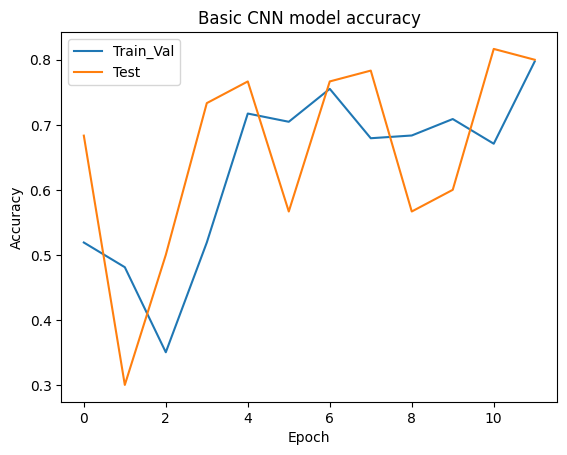

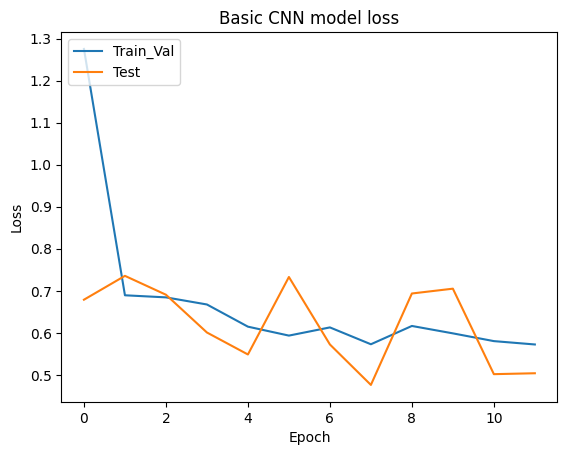

In [ ]:
# Plot training and validation accuracy curves
plt.plot(basic_cnn_history.history['accuracy'])
plt.plot(basic_cnn_history.history['val_accuracy'])
plt.title('Basic CNN model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_Val', 'Test'], loc='upper left')
plt.show()

# Plot training and validation loss curves
plt.plot(basic_cnn_history.history['loss'])
plt.plot(basic_cnn_history.history['val_loss'])
plt.title('Basic CNN model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_Val', 'Test'], loc='upper left')
plt.show()

## Test the performance of the Basic CNN model on the test set.

In [ ]:
# Evaluate model performance on test set
performance_basic_cnn = model.evaluate(test)
print('Test loss:', performance_basic_cnn[0])
print('Test accuracy:', performance_basic_cnn[1])

2/2 [==============================] - 11s 5s/step - loss: 0.5040 - accuracy: 0.8000 - recall: 0.8571 - precision: 0.8571
Test loss: 0.5039722323417664
Test accuracy: 0.800000011920929


In [ ]:
# Use the trained model to predict on the test set and round the prediction
y_pred = model.predict(test)
y_pred = np.round(y_pred)

# Calculate the evaluation metrics
accuracy = accuracy_score(test.labels, y_pred)
precision = precision_score(test.labels, y_pred)
recall = recall_score(test.labels, y_pred)
f1score = f1_score(test.labels, y_pred)
f1score_macro = f1_score(test.labels, y_pred, average = 'macro')
auc_roc = roc_auc_score(test.labels, y_pred)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(test.labels, y_pred))

2/2 [==============================] - 11s 5s/step
Accuracy: 0.8
Precision: 0.8571428571428571
Recall: 0.8571428571428571
F1-score: 0.8571428571428571
F1_score_macro: 0.7619047619047619
AUC-ROC: 0.7619047619047621

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        18
           1       0.86      0.86      0.86        42

    accuracy                           0.80        60
   macro avg       0.76      0.76      0.76        60
weighted avg       0.80      0.80      0.80        60



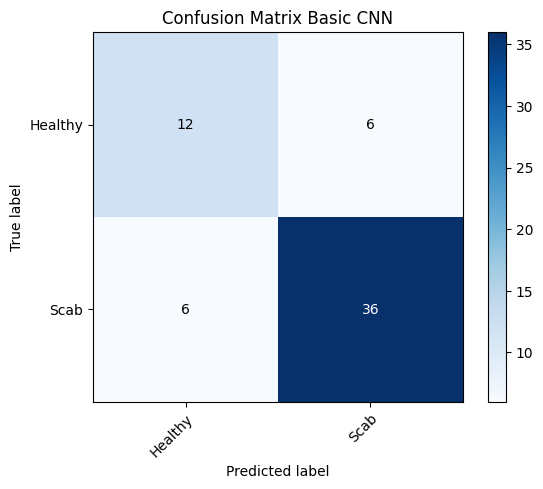

In [ ]:
# Create a confusion matrix:
cm = confusion_matrix(test.labels, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix Basic CNN")
plt.show()

#  ResNet50V2 model:

## Perform hyperparameter tuning on the ResNet50V2 model.

In [ ]:
def hp_fruits_ResNet50V2(trail):

  clear_session()

  # preprocess data
  train, val, train_val, test = train_val_test_generators(train_dir, val_dir, train_val_dir, test_dir)

  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train.classes), y = train.classes)
  class_weights = {i : class_weights[i] for i in range(2)}

  # build model
  from tensorflow.keras.applications import ResNet50V2
  from tensorflow.keras import layers

  ResNet50V2_model = ResNet50V2(input_shape = (224, 224, 3), 
                                  include_top = False, 
                                  weights = 'imagenet')

  for layer in ResNet50V2_model.layers:
    layer.trainable = False

  last_output = ResNet50V2_model.output
  x = layers.Flatten()(last_output)
  
  hidden_layers = trail.suggest_int('hidden_layers', 1, 2)

  for i in range(hidden_layers):
    first_neuron = trail.suggest_categorical('first_neuron', [128, 256, 512])
    x = layers.Dense(first_neuron, activation='relu')(x)
    drop_out = trail.suggest_categorical('drop_out', [0, 0.3, 0.5])
    x = layers.Dropout(drop_out)(x)                  
  
  x = layers.Dense(1, activation='sigmoid')(x)           

  model = Model(ResNet50V2_model.input, x) 

  # compile/train model
  optimizer_name = trail.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'AdamW'])
  learning_rate = trail.suggest_float('lr', 1e-5, 1e-2, log=True)

  if optimizer_name == 'Adam':
      optimizer = Adam(learning_rate=learning_rate)
  elif optimizer_name == 'RMSprop':
      optimizer = RMSprop(learning_rate=learning_rate)
  elif optimizer_name == 'AdamW':
      optimizer = AdamW(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,
                loss = 'binary_crossentropy', 
                metrics = ['accuracy', Recall(), Precision()])
  
  early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
  
  model.fit(train, validation_data=val, class_weight=class_weights, epochs = 100, callbacks=[early_stop],
            max_queue_size=40, workers=4, use_multiprocessing=True)
  
  # evaluate macro f1 score
  
  y_pred_val = model.predict(val)
  y_pred_val = np.round(y_pred_val)

  f1score_macro = f1_score(val.labels, y_pred_val, average = 'macro')
  acc = accuracy_score(val.labels, y_pred_val)
  print(f1score_macro)
  print(acc)
  
  return f1score_macro

if __name__ == "__main__":
    warnings.warn(
        "Recent Keras release (2.4.0) simply redirects all APIs "
        "in the standalone keras package to point to tf.keras. "
        "There is now only one Keras: tf.keras. "
        "There may be some breaking changes for some workflows by upgrading to keras 2.4.0. "
        "Test before upgrading. "
        "REF:https://github.com/keras-team/keras/releases/tag/2.4.0"
    )
    study = optuna.create_study(direction="maximize")
    study.optimize(hp_fruits_ResNet50V2, n_trials=10)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

<ipython-input-6-764d0bf4a10e>:70: UserWarning: Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  warnings.warn(
[I 2023-05-14 12:04:37,304] A new study created in memory with name: no-name-d81a400f-2506-4265-9cc7-3e86f5f52503


Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
94668760/94668760 [==============================] - 3s 0us/step
Epoch 1/100
6/6 [==============================] - 63s 9s/step - loss: 360.9401 - accuracy: 0.5674 - recall: 0.5887 - precision: 0.7374 - val_loss: 77.0816 - val_accuracy: 0.6949 - val_recall: 1.0000 - val_precision: 0.6949
Epoch 2/100
6/6 [==============================] - 26s 4s/step - loss: 58.2953 - accuracy: 0.7809 - recall: 0.8145 - precision: 0.8632 - val_loss: 16.6566 - val_accuracy: 0.7966 - val_recall: 0.8537 - val_precision: 0.8537
Epoch 3/100
6/6 [==============================] - 26s 4s/step - loss: 25.8846 - accuracy: 0.7584 - recall: 0.7500 - precision: 0.8857 - val_loss: 22.0902 - val_accuracy: 0.7627 - val_recall: 0.9756 - val_precision: 0.7547
Epoch 4/100
6/6 [==============================] - 28s 4s/step - loss: 9.0446 - accuracy: 0.8764 - reca

[I 2023-05-14 12:20:18,836] Trial 0 finished with value: 0.7893541058098019 and parameters: {'hidden_layers': 1, 'first_neuron': 256, 'drop_out': 0, 'optimizer': 'RMSprop', 'lr': 0.00796621741787561}. Best is trial 0 with value: 0.7893541058098019.


0.7893541058098019
0.8135593220338984
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 40s 6s/step - loss: 10.5957 - accuracy: 0.6798 - recall: 0.7581 - precision: 0.7769 - val_loss: 4.2571 - val_accuracy: 0.6949 - val_recall: 0.6098 - val_precision: 0.9259
Epoch 2/100
6/6 [==============================] - 29s 4s/step - loss: 3.7764 - accuracy: 0.7528 - recall: 0.7097 - precision: 0.9167 - val_loss: 2.6257 - val_accuracy: 0.8305 - val_recall: 1.0000 - val_precision: 0.8039
Epoch 3/100
6/6 [==============================] - 29s 5s/step - loss: 4.8589 - accuracy: 0.7809 - recall: 0.8226 - precision: 0.8571 - val_loss: 6.1071 - val_accuracy: 0.7627 - val_recall: 0.6585 - val_precision: 1.0000
Epoch 4/100
6/6 [==============================] - 28s 4s/step - loss: 4.3429 - accuracy: 0.7528 - recall: 0.7339 - precision: 0.8922 - 

[I 2023-05-14 12:30:03,439] Trial 1 finished with value: 0.751054852320675 and parameters: {'hidden_layers': 1, 'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'AdamW', 'lr': 0.0008962560267656224}. Best is trial 0 with value: 0.7893541058098019.


0.751054852320675
0.7796610169491526
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 40s 6s/step - loss: 1.1926 - accuracy: 0.6798 - recall: 0.7177 - precision: 0.8018 - val_loss: 0.8393 - val_accuracy: 0.7288 - val_recall: 0.7561 - val_precision: 0.8378
Epoch 2/100
6/6 [==============================] - 30s 4s/step - loss: 1.3513 - accuracy: 0.7697 - recall: 0.7984 - precision: 0.8609 - val_loss: 1.1130 - val_accuracy: 0.7119 - val_recall: 0.6829 - val_precision: 0.8750
Epoch 3/100
6/6 [==============================] - 30s 5s/step - loss: 0.7039 - accuracy: 0.8708 - recall: 0.8871 - precision: 0.9244 - val_loss: 1.1743 - val_accuracy: 0.7288 - val_recall: 0.6829 - val_precision: 0.9032
Epoch 4/100
6/6 [==============================] - 29s 5s/step - loss: 0.7709 - accuracy: 0.8596 - recall: 0.8710 - precision: 0.9231 - va

[I 2023-05-14 12:37:27,998] Trial 2 finished with value: 0.7601626016260162 and parameters: {'hidden_layers': 1, 'first_neuron': 512, 'drop_out': 0.5, 'optimizer': 'AdamW', 'lr': 6.634071842855295e-05}. Best is trial 0 with value: 0.7893541058098019.


0.7601626016260162
0.7966101694915254
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 39s 6s/step - loss: 1.4956 - accuracy: 0.6685 - recall: 0.7258 - precision: 0.7826 - val_loss: 1.3120 - val_accuracy: 0.7288 - val_recall: 0.6341 - val_precision: 0.9630
Epoch 2/100
6/6 [==============================] - 30s 4s/step - loss: 0.9264 - accuracy: 0.7528 - recall: 0.7177 - precision: 0.9082 - val_loss: 0.8112 - val_accuracy: 0.7966 - val_recall: 0.7805 - val_precision: 0.9143
Epoch 3/100
6/6 [==============================] - 31s 5s/step - loss: 0.8568 - accuracy: 0.8539 - recall: 0.9032 - precision: 0.8889 - val_loss: 1.2546 - val_accuracy: 0.7797 - val_recall: 0.6829 - val_precision: 1.0000
Epoch 4/100
6/6 [==============================] - 30s 5s/step - loss: 0.8758 - accuracy: 0.7472 - recall: 0.6935 - precision: 0.9247 - v

[I 2023-05-14 12:41:41,142] Trial 3 finished with value: 0.7781954887218046 and parameters: {'hidden_layers': 1, 'first_neuron': 512, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 3.087900390754234e-05}. Best is trial 0 with value: 0.7893541058098019.


0.7781954887218046
0.7966101694915254
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 38s 6s/step - loss: 86.3359 - accuracy: 0.6124 - recall: 0.7016 - precision: 0.7311 - val_loss: 10.4752 - val_accuracy: 0.6949 - val_recall: 0.5610 - val_precision: 1.0000
Epoch 2/100
6/6 [==============================] - 31s 4s/step - loss: 13.3258 - accuracy: 0.6517 - recall: 0.6694 - precision: 0.7981 - val_loss: 9.1174 - val_accuracy: 0.7288 - val_recall: 0.6341 - val_precision: 0.9630
Epoch 3/100
6/6 [==============================] - 28s 4s/step - loss: 5.1355 - accuracy: 0.7978 - recall: 0.7823 - precision: 0.9151 - val_loss: 5.1070 - val_accuracy: 0.7797 - val_recall: 0.7561 - val_precision: 0.9118
Epoch 4/100
6/6 [==============================] - 29s 4s/step - loss: 2.8550 - accuracy: 0.8427 - recall: 0.8468 - precision: 0.9211 

2/2 [==============================] - 12s 5s/step


[I 2023-05-14 12:53:52,302] Trial 4 finished with value: 0.8276533592989289 and parameters: {'hidden_layers': 1, 'first_neuron': 256, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 0.0014541238809524042}. Best is trial 4 with value: 0.8276533592989289.


0.8276533592989289
0.847457627118644
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 38s 5s/step - loss: 5.9665 - accuracy: 0.5955 - recall: 0.5645 - precision: 0.7955 - val_loss: 1.0055 - val_accuracy: 0.7119 - val_recall: 0.7805 - val_precision: 0.8000
Epoch 2/100
6/6 [==============================] - 30s 4s/step - loss: 2.7772 - accuracy: 0.7809 - recall: 0.9355 - precision: 0.7891 - val_loss: 1.4272 - val_accuracy: 0.7119 - val_recall: 0.6585 - val_precision: 0.9000
Epoch 3/100
6/6 [==============================] - 29s 4s/step - loss: 1.5421 - accuracy: 0.6517 - recall: 0.5403 - precision: 0.9306 - val_loss: 1.9349 - val_accuracy: 0.6780 - val_recall: 0.5366 - val_precision: 1.0000
Epoch 4/100
6/6 [==============================] - 28s 4s/step - loss: 0.7550 - accuracy: 0.7865 - recall: 0.7742 - precision: 0.9057 - va

2/2 [==============================] - 12s 5s/step


[I 2023-05-14 13:00:46,289] Trial 5 finished with value: 0.7359724612736662 and parameters: {'hidden_layers': 1, 'first_neuron': 512, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.00020657395284535428}. Best is trial 4 with value: 0.8276533592989289.


0.7359724612736662
0.7796610169491526
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 40s 6s/step - loss: 1.8125 - accuracy: 0.6348 - recall: 0.7984 - precision: 0.7122 - val_loss: 1.1426 - val_accuracy: 0.4746 - val_recall: 0.2927 - val_precision: 0.8571
Epoch 2/100
6/6 [==============================] - 30s 4s/step - loss: 1.2041 - accuracy: 0.6124 - recall: 0.5403 - precision: 0.8481 - val_loss: 0.8923 - val_accuracy: 0.5763 - val_recall: 0.4390 - val_precision: 0.9000
Epoch 3/100
6/6 [==============================] - 29s 4s/step - loss: 1.2134 - accuracy: 0.6685 - recall: 0.6935 - precision: 0.8037 - val_loss: 0.4169 - val_accuracy: 0.7797 - val_recall: 0.8049 - val_precision: 0.8684
Epoch 4/100
6/6 [==============================] - 29s 5s/step - loss: 0.7818 - accuracy: 0.8146 - recall: 0.8871 - precision: 0.8527 - v

[I 2023-05-14 13:05:31,793] Trial 6 finished with value: 0.751054852320675 and parameters: {'hidden_layers': 2, 'first_neuron': 128, 'drop_out': 0.5, 'optimizer': 'AdamW', 'lr': 8.19135350690596e-05}. Best is trial 4 with value: 0.8276533592989289.


0.751054852320675
0.7796610169491526
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 39s 6s/step - loss: 6.4427 - accuracy: 0.6124 - recall: 0.6532 - precision: 0.7570 - val_loss: 6.4267 - val_accuracy: 0.4576 - val_recall: 0.2195 - val_precision: 1.0000
Epoch 2/100
6/6 [==============================] - 33s 5s/step - loss: 1.6285 - accuracy: 0.7697 - recall: 0.7581 - precision: 0.8952 - val_loss: 1.2063 - val_accuracy: 0.7797 - val_recall: 0.8780 - val_precision: 0.8182
Epoch 3/100
6/6 [==============================] - 29s 5s/step - loss: 0.7369 - accuracy: 0.8539 - recall: 0.8710 - precision: 0.9153 - val_loss: 1.5056 - val_accuracy: 0.7966 - val_recall: 0.7805 - val_precision: 0.9143
Epoch 4/100
6/6 [==============================] - 29s 4s/step - loss: 0.6859 - accuracy: 0.8258 - recall: 0.7903 - precision: 0.9515 - va

[I 2023-05-14 13:13:09,698] Trial 7 finished with value: 0.776592082616179 and parameters: {'hidden_layers': 1, 'first_neuron': 512, 'drop_out': 0, 'optimizer': 'Adam', 'lr': 0.00021349851915816983}. Best is trial 4 with value: 0.8276533592989289.


0.776592082616179
0.8135593220338984
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 41s 6s/step - loss: 0.8127 - accuracy: 0.6685 - recall: 0.7016 - precision: 0.7982 - val_loss: 0.6216 - val_accuracy: 0.6949 - val_recall: 0.6585 - val_precision: 0.8710
Epoch 2/100
6/6 [==============================] - 30s 4s/step - loss: 0.3852 - accuracy: 0.8315 - recall: 0.8871 - precision: 0.8730 - val_loss: 0.4078 - val_accuracy: 0.7966 - val_recall: 0.8293 - val_precision: 0.8718
Epoch 3/100
6/6 [==============================] - 30s 4s/step - loss: 0.4403 - accuracy: 0.8483 - recall: 0.8468 - precision: 0.9292 - val_loss: 0.5046 - val_accuracy: 0.7966 - val_recall: 0.8049 - val_precision: 0.8919
Epoch 4/100
6/6 [==============================] - 28s 4s/step - loss: 0.2523 - accuracy: 0.8933 - recall: 0.8952 - precision: 0.9487 - va

[I 2023-05-14 13:17:23,317] Trial 8 finished with value: 0.7671052631578947 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 2.9205617669261755e-05}. Best is trial 4 with value: 0.8276533592989289.


0.7671052631578947
0.7966101694915254
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 42s 6s/step - loss: 321.5877 - accuracy: 0.4775 - recall: 0.4677 - precision: 0.6824 - val_loss: 9.3867 - val_accuracy: 0.6949 - val_recall: 1.0000 - val_precision: 0.6949
Epoch 2/100
6/6 [==============================] - 31s 4s/step - loss: 6.1926 - accuracy: 0.6180 - recall: 0.6694 - precision: 0.7545 - val_loss: 0.9456 - val_accuracy: 0.7288 - val_recall: 0.6829 - val_precision: 0.9032
Epoch 3/100
6/6 [==============================] - 31s 4s/step - loss: 1.4823 - accuracy: 0.6854 - recall: 0.6774 - precision: 0.8400 - val_loss: 0.6950 - val_accuracy: 0.7797 - val_recall: 0.7805 - val_precision: 0.8889
Epoch 4/100
6/6 [==============================] - 28s 4s/step - loss: 0.6307 - accuracy: 0.7809 - recall: 0.7742 - precision: 0.8972 -

[I 2023-05-14 13:22:14,802] Trial 9 finished with value: 0.7570478302185619 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0, 'optimizer': 'RMSprop', 'lr': 0.0025450732854980116}. Best is trial 4 with value: 0.8276533592989289.


0.7570478302185619
0.7796610169491526
Number of finished trials: 10
Best trial:
  Value: 0.8276533592989289
  Params: 
    hidden_layers: 1
    first_neuron: 256
    drop_out: 0.3
    optimizer: RMSprop
    lr: 0.0014541238809524042


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_hidden_layers,params_lr,params_optimizer,state
0,0,0.789354,2023-05-14 12:04:37.308325,2023-05-14 12:20:18.836085,0 days 00:15:41.527760,0.0,256,1,0.007966,RMSprop,COMPLETE
1,1,0.751055,2023-05-14 12:20:18.838271,2023-05-14 12:30:03.439062,0 days 00:09:44.600791,0.5,256,1,0.000896,AdamW,COMPLETE
2,2,0.760163,2023-05-14 12:30:03.441357,2023-05-14 12:37:27.997466,0 days 00:07:24.556109,0.5,512,1,0.000066,AdamW,COMPLETE
3,3,0.778195,2023-05-14 12:37:27.999541,2023-05-14 12:41:41.141292,0 days 00:04:13.141751,0.5,512,1,0.000031,Adam,COMPLETE
4,4,0.827653,2023-05-14 12:41:41.143620,2023-05-14 12:53:52.301776,0 days 00:12:11.158156,0.3,256,1,0.001454,RMSprop,COMPLETE
5,5,0.735972,2023-05-14 12:53:52.305271,2023-05-14 13:00:46.288581,0 days 00:06:53.983310,0.3,512,1,0.000207,Adam,COMPLETE
6,6,0.751055,2023-05-14 13:00:46.290736,2023-05-14 13:05:31.792350,0 days 00:04:45.501614,0.5,128,2,0.000082,AdamW,COMPLETE
7,7,0.776592,2023-05-14 13:05:31.795604,2023-05-14 13:13:09.697528,0 days 00:07:37.901924,0.0,512,1,0.000213,Adam,COMPLETE
8,8,0.767105,2023-05-14 13:13:09.699696,2023-05-14 13:17:23.316370,0 days 00:04:13.616674,0.0,512,2,0.000029,AdamW,COMPLETE
9,9,0.757048,2023-05-14 13:17:23.318512,2023-05-14 13:22:14.801968,0 days 00:04:51.483456,0.0,512,2,0.002545,RMSprop,COMPLETE


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
from google.colab import runtime
runtime.unassign()

## Re-train the ResNet50V2 model using the best hyperparameters.

In [ ]:
clear_session()

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers

# preprocess data
train, val, train_val, test = train_val_test_generators(train_dir, val_dir, train_val_dir, test_dir)

class_weights_train_val = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_val.classes), y = train_val.classes)
class_weights_train_val = {i : class_weights_train_val[i] for i in range(2)}

# get best hyperparameters
best_hidden_layers = 1 #study.best_params['hidden_layers']
best_neurons = 256# study.best_params['first_neuron']
best_dropout = 0.3	#study.best_params['drop_out']
best_optimizer = 'RMSprop'	#study.best_params['optimizer']
best_lr = 0.001454	#study.best_params['lr']
epochs = 18 # take best epoch from HP tuning trail

# retrain model
ResNet50V2_model = ResNet50V2(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = 'imagenet')

for layer in ResNet50V2_model.layers:
  layer.trainable = False

last_output = ResNet50V2_model.output
x = layers.Flatten()(last_output)

for i in range(best_hidden_layers):
  x = layers.Dense(best_neurons, activation='relu')(x)
  x = layers.Dropout(best_dropout)(x)                  

x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(ResNet50V2_model.input, x) 

if best_optimizer == 'Adam':
    optimizer = Adam(learning_rate=best_lr)
elif best_optimizer == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_lr)
elif best_optimizer == 'AdamW':
    optimizer = AdamW(learning_rate=best_lr)


model.compile(optimizer=optimizer,
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', Recall(), Precision()])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

ResNet50V2_history = model.fit(train_val, validation_data=test, # test set used only for monitoring loss and accuracy, not for HP tuning
                               class_weight=class_weights_train_val, epochs = epochs,
                               max_queue_size=40, workers=4, use_multiprocessing=True)

Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
94668760/94668760 [==============================] - 3s 0us/step
Epoch 1/18
8/8 [==============================] - 69s 7s/step - loss: 50.8541 - accuracy: 0.5781 - recall: 0.6000 - precision: 0.7444 - val_loss: 20.9749 - val_accuracy: 0.4333 - val_recall: 0.1905 - val_precision: 1.0000
Epoch 2/18
8/8 [==============================] - 26s 3s/step - loss: 4.9715 - accuracy: 0.7215 - recall: 0.6970 - precision: 0.8779 - val_loss: 1.7513 - val_accuracy: 0.8333 - val_recall: 0.8095 - val_precision: 0.9444
Epoch 3/18
8/8 [==============================] - 27s 3s/step - loss: 3.3760 - accuracy: 0.7553 - recall: 0.7576 - precision: 0.8741 - val_loss: 1.9549 - val_accuracy: 0.8000 - val_recall: 0.7381 - val_precision: 0.9688
Epoch 4/18
8/8 [==============================] - 27s 3s/step - loss: 1.4458 - accuracy: 0.7764 - recall: 0.769

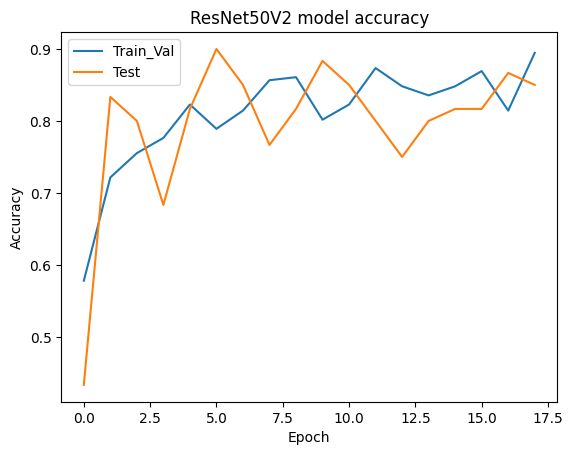

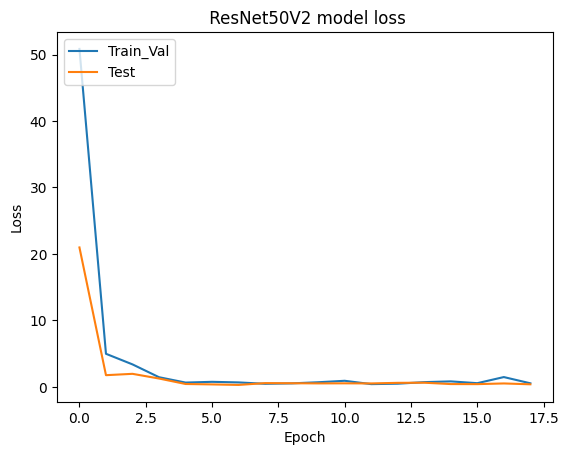

In [ ]:
# Plot training and validation accuracy curves
plt.plot(ResNet50V2_history.history['accuracy'])
plt.plot(ResNet50V2_history.history['val_accuracy'])
plt.title('ResNet50V2 model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_Val', 'Test'], loc='upper left')
plt.show()

# Plot training and validation loss curves
plt.plot(ResNet50V2_history.history['loss'])
plt.plot(ResNet50V2_history.history['val_loss'])
plt.title(' ResNet50V2 model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_Val', 'Test'], loc='upper left')
plt.show()

## Test the performance of the ResNet50V2 model on the test set.

In [ ]:
# Evaluate model performance on test set
performance_ResNet50V2 = model.evaluate(test)
print('Test loss:', performance_ResNet50V2[0])
print('Test accuracy:', performance_ResNet50V2[1])

2/2 [==============================] - 10s 5s/step - loss: 0.3789 - accuracy: 0.8500 - recall: 0.8571 - precision: 0.9231
Test loss: 0.3789285123348236
Test accuracy: 0.8500000238418579


In [ ]:
# Use the trained model to predict on the test set and round the prediction
y_pred = model.predict(test)
y_pred = np.round(y_pred)

# Calculate the evaluation metrics
accuracy = accuracy_score(test.labels, y_pred)
precision = precision_score(test.labels, y_pred)
recall = recall_score(test.labels, y_pred)
f1score = f1_score(test.labels, y_pred)
f1score_macro = f1_score(test.labels, y_pred, average = 'macro')
auc_roc = roc_auc_score(test.labels, y_pred)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(test.labels, y_pred))

2/2 [==============================] - 11s 5s/step
Accuracy: 0.85
Precision: 0.9230769230769231
Recall: 0.8571428571428571
F1-score: 0.888888888888889
F1_score_macro: 0.829059829059829
AUC-ROC: 0.8452380952380952

              precision    recall  f1-score   support

           0       0.71      0.83      0.77        18
           1       0.92      0.86      0.89        42

    accuracy                           0.85        60
   macro avg       0.82      0.85      0.83        60
weighted avg       0.86      0.85      0.85        60



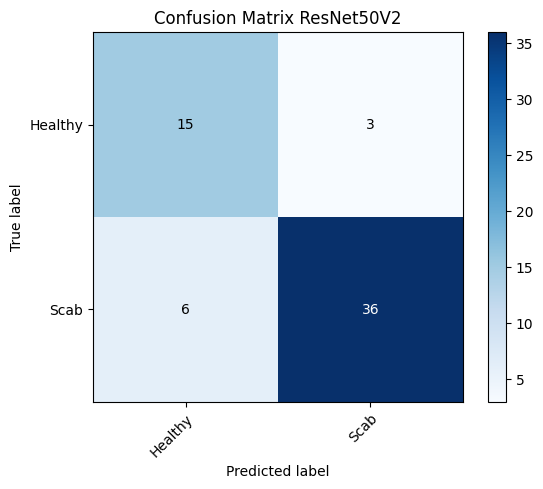

In [ ]:
# Create a confusion matrix:
cm = confusion_matrix(test.labels, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix ResNet50V2")
plt.show()

# EfficientNetV2B0 model:

## Perform hyperparameter tuning on the EfficientNetV2B0 model.

In [ ]:
def hp_fruits_EfficientNetV2B0(trail):

  clear_session()

  # preprocess data
  train, val, train_val, test = train_val_test_generators(train_dir, val_dir, train_val_dir, test_dir)

  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train.classes), y = train.classes)
  class_weights = {i : class_weights[i] for i in range(2)}

  # build model
  from tensorflow.keras.applications import EfficientNetV2B0
  from tensorflow.keras import layers

  EfficientNetV2B0_model = EfficientNetV2B0(input_shape = (224, 224, 3), 
                                  include_top = False, 
                                  weights = 'imagenet',
                                  include_preprocessing = False)

  for layer in EfficientNetV2B0_model.layers:
    layer.trainable = False

  last_output = EfficientNetV2B0_model.output
  x = layers.Flatten()(last_output)
  
  hidden_layers = trail.suggest_int('hidden_layers', 1, 2)

  for i in range(hidden_layers):
    first_neuron = trail.suggest_categorical('first_neuron', [128, 256, 512])
    x = layers.Dense(first_neuron, activation='relu')(x)
    drop_out = trail.suggest_categorical('drop_out', [0, 0.3, 0.5])
    x = layers.Dropout(drop_out)(x)                  
  
  x = layers.Dense(1, activation='sigmoid')(x)           

  model = Model(EfficientNetV2B0_model.input, x)

  # compile/train model
  optimizer_name = trail.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'AdamW'])
  learning_rate = trail.suggest_float('lr', 1e-5, 1e-2, log=True)

  if optimizer_name == 'Adam':
      optimizer = Adam(learning_rate=learning_rate)
  elif optimizer_name == 'RMSprop':
      optimizer = RMSprop(learning_rate=learning_rate)
  elif optimizer_name == 'AdamW':
      optimizer = AdamW(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,
                loss = 'binary_crossentropy', 
                metrics = ['accuracy', Recall(), Precision()])
  
  early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  model.fit(train, validation_data=val, class_weight=class_weights, epochs = 100, callbacks=[early_stop],
            max_queue_size=20, workers=2, use_multiprocessing=True)
  
  # evaluate macro f1 score
  y_pred_val = model.predict(val)
  y_pred_val = np.round(y_pred_val)

  f1score_macro = f1_score(val.labels, y_pred_val, average = 'macro')
  acc = accuracy_score(val.labels, y_pred_val)
  print(f1score_macro)
  print(acc)
  
  return f1score_macro

if __name__ == "__main__":
    warnings.warn(
        "Recent Keras release (2.4.0) simply redirects all APIs "
        "in the standalone keras package to point to tf.keras. "
        "There is now only one Keras: tf.keras. "
        "There may be some breaking changes for some workflows by upgrading to keras 2.4.0. "
        "Test before upgrading. "
        "REF:https://github.com/keras-team/keras/releases/tag/2.4.0"
    )
    study = optuna.create_study(direction="maximize")
    study.optimize(hp_fruits_EfficientNetV2B0, n_trials=10)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

<ipython-input-9-2c637992ec41>:70: UserWarning: Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  warnings.warn(
[I 2023-05-14 17:51:24,650] A new study created in memory with name: no-name-b3ce4aa2-e13e-4e88-8633-68151a1625fa


Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
24274472/24274472 [==============================] - 1s 0us/step
Epoch 1/100
6/6 [==============================] - 82s 11s/step - loss: 1.6431 - accuracy: 0.5674 - recall: 0.6452 - precision: 0.7080 - val_loss: 3.1925 - val_accuracy: 0.4068 - val_recall: 0.1463 - val_precision: 1.0000
Epoch 2/100
6/6 [==============================] - 32s 5s/step - loss: 1.0967 - accuracy: 0.6348 - recall: 0.6129 - precision: 0.8172 - val_loss: 0.7646 - val_accuracy: 0.6949 - val_recall: 0.8537 - val_precision: 0.7447
Epoch 3/100
6/6 [==============================] - 34s 5s/step - loss: 0.6480 - accuracy: 0.7472 - recall: 0.8306 - precision: 0.8110 - val_loss: 0.6968 - val_accuracy: 0.6780 - val_recall: 0.5854 - val_precision: 0.9231
Epoch 4/100
6/6 [==============================] - 33s 5s/step - loss: 0.4441 - accuracy: 0.7360 - recall: 0.

[I 2023-05-14 17:58:37,994] Trial 0 finished with value: 0.665331998665332 and parameters: {'hidden_layers': 1, 'first_neuron': 256, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 0.0002559426389112665}. Best is trial 0 with value: 0.665331998665332.


0.665331998665332
0.711864406779661
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 48s 6s/step - loss: 4.0295 - accuracy: 0.5787 - recall: 0.6290 - precision: 0.7290 - val_loss: 3.4932 - val_accuracy: 0.3220 - val_recall: 0.0244 - val_precision: 1.0000
Epoch 2/100
6/6 [==============================] - 32s 6s/step - loss: 1.0191 - accuracy: 0.6742 - recall: 0.6774 - precision: 0.8235 - val_loss: 1.7763 - val_accuracy: 0.4237 - val_recall: 0.1707 - val_precision: 1.0000
Epoch 3/100
6/6 [==============================] - 34s 5s/step - loss: 0.5266 - accuracy: 0.7584 - recall: 0.7581 - precision: 0.8785 - val_loss: 1.0036 - val_accuracy: 0.5254 - val_recall: 0.3659 - val_precision: 0.8824
Epoch 4/100
6/6 [==============================] - 32s 5s/step - loss: 0.7009 - accuracy: 0.6966 - recall: 0.7258 - precision: 0.8182 - val

[I 2023-05-14 18:06:45,723] Trial 1 finished with value: 0.7040133779264215 and parameters: {'hidden_layers': 2, 'first_neuron': 128, 'drop_out': 0, 'optimizer': 'RMSprop', 'lr': 0.0004988519577206311}. Best is trial 1 with value: 0.7040133779264215.


0.7040133779264215
0.7966101694915254
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 47s 7s/step - loss: 5.1955 - accuracy: 0.5787 - recall: 0.6452 - precision: 0.7207 - val_loss: 4.8225 - val_accuracy: 0.5254 - val_recall: 0.3171 - val_precision: 1.0000
Epoch 2/100
6/6 [==============================] - 33s 5s/step - loss: 2.3609 - accuracy: 0.6629 - recall: 0.6048 - precision: 0.8721 - val_loss: 1.8338 - val_accuracy: 0.7627 - val_recall: 0.8780 - val_precision: 0.8000
Epoch 3/100
6/6 [==============================] - 31s 5s/step - loss: 2.1466 - accuracy: 0.6910 - recall: 0.7097 - precision: 0.8224 - val_loss: 2.9454 - val_accuracy: 0.4407 - val_recall: 0.2683 - val_precision: 0.7857
Epoch 4/100
6/6 [==============================] - 34s 6s/step - loss: 0.9208 - accuracy: 0.7753 - recall: 0.7581 - precision: 0.9038 - v

[I 2023-05-14 18:15:57,773] Trial 2 finished with value: 0.665331998665332 and parameters: {'hidden_layers': 1, 'first_neuron': 256, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.0010113781206354472}. Best is trial 1 with value: 0.7040133779264215.


0.665331998665332
0.711864406779661
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 49s 7s/step - loss: 1.0118 - accuracy: 0.5281 - recall: 0.5403 - precision: 0.7128 - val_loss: 1.1245 - val_accuracy: 0.4746 - val_recall: 0.2439 - val_precision: 1.0000
Epoch 2/100
6/6 [==============================] - 35s 6s/step - loss: 0.6721 - accuracy: 0.6517 - recall: 0.6855 - precision: 0.7870 - val_loss: 0.5755 - val_accuracy: 0.6949 - val_recall: 0.8293 - val_precision: 0.7556
Epoch 3/100
6/6 [==============================] - 31s 5s/step - loss: 0.5010 - accuracy: 0.7303 - recall: 0.7097 - precision: 0.8800 - val_loss: 0.8516 - val_accuracy: 0.6102 - val_recall: 0.4634 - val_precision: 0.9500
Epoch 4/100
6/6 [==============================] - 33s 5s/step - loss: 0.5092 - accuracy: 0.7416 - recall: 0.6935 - precision: 0.9149 - val

[I 2023-05-14 18:24:40,724] Trial 3 finished with value: 0.7127555988315482 and parameters: {'hidden_layers': 1, 'first_neuron': 512, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 2.943358124114779e-05}. Best is trial 3 with value: 0.7127555988315482.


0.7127555988315482
0.7457627118644068
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 48s 7s/step - loss: 2.6133 - accuracy: 0.5449 - recall: 0.5806 - precision: 0.7129 - val_loss: 0.9088 - val_accuracy: 0.6780 - val_recall: 0.7317 - val_precision: 0.7895
Epoch 2/100
6/6 [==============================] - 34s 5s/step - loss: 0.8899 - accuracy: 0.7135 - recall: 0.7661 - precision: 0.8120 - val_loss: 2.1307 - val_accuracy: 0.4068 - val_recall: 0.1951 - val_precision: 0.8000
Epoch 3/100
6/6 [==============================] - 32s 6s/step - loss: 0.7879 - accuracy: 0.6910 - recall: 0.7258 - precision: 0.8108 - val_loss: 1.5272 - val_accuracy: 0.4915 - val_recall: 0.3171 - val_precision: 0.8667
Epoch 4/100
6/6 [==============================] - 32s 5s/step - loss: 0.6026 - accuracy: 0.7584 - recall: 0.7500 - precision: 0.8857 - v

2/2 [==============================] - 13s 5s/step


[I 2023-05-14 18:34:05,126] Trial 4 finished with value: 0.6571096474234793 and parameters: {'hidden_layers': 1, 'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 0.00012147377870904602}. Best is trial 3 with value: 0.7127555988315482.


0.6571096474234793
0.7457627118644068
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 50s 7s/step - loss: 5.9197 - accuracy: 0.5506 - recall: 0.6210 - precision: 0.7000 - val_loss: 0.7411 - val_accuracy: 0.7288 - val_recall: 0.8537 - val_precision: 0.7778
Epoch 2/100
6/6 [==============================] - 34s 5s/step - loss: 5.5044 - accuracy: 0.6067 - recall: 0.6855 - precision: 0.7328 - val_loss: 1.7401 - val_accuracy: 0.6271 - val_recall: 0.7561 - val_precision: 0.7209
Epoch 3/100
6/6 [==============================] - 31s 6s/step - loss: 5.4196 - accuracy: 0.5562 - recall: 0.5000 - precision: 0.7848 - val_loss: 3.4950 - val_accuracy: 0.5085 - val_recall: 0.3171 - val_precision: 0.9286
Epoch 4/100
6/6 [==============================] - 31s 5s/step - loss: 4.0923 - accuracy: 0.6742 - recall: 0.6774 - precision: 0.8235 - v

2/2 [==============================] - 14s 6s/step


[I 2023-05-14 18:38:25,445] Trial 5 finished with value: 0.6569767441860465 and parameters: {'hidden_layers': 2, 'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 0.0017501679972344796}. Best is trial 3 with value: 0.7127555988315482.


0.6569767441860465
0.7288135593220338
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 51s 7s/step - loss: 167.6902 - accuracy: 0.5562 - recall: 0.6532 - precision: 0.6923 - val_loss: 5.9358 - val_accuracy: 0.5932 - val_recall: 0.5854 - val_precision: 0.7742
Epoch 2/100
6/6 [==============================] - 31s 5s/step - loss: 20.3610 - accuracy: 0.4944 - recall: 0.3952 - precision: 0.7656 - val_loss: 6.4375 - val_accuracy: 0.6780 - val_recall: 0.9756 - val_precision: 0.6897
Epoch 3/100
6/6 [==============================] - 33s 5s/step - loss: 11.8246 - accuracy: 0.6461 - recall: 0.8145 - precision: 0.7163 - val_loss: 3.1303 - val_accuracy: 0.5932 - val_recall: 0.5610 - val_precision: 0.7931
Epoch 4/100
6/6 [==============================] - 33s 5s/step - loss: 6.0168 - accuracy: 0.5112 - recall: 0.3790 - precision: 0.8246

[I 2023-05-14 18:53:15,245] Trial 6 finished with value: 0.7047047047047048 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 0.00990778066702715}. Best is trial 3 with value: 0.7127555988315482.


0.7047047047047048
0.7457627118644068
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 50s 7s/step - loss: 8.7662 - accuracy: 0.6292 - recall: 0.6210 - precision: 0.8021 - val_loss: 3.1962 - val_accuracy: 0.7458 - val_recall: 0.9756 - val_precision: 0.7407
Epoch 2/100
6/6 [==============================] - 33s 5s/step - loss: 7.8043 - accuracy: 0.6011 - recall: 0.6613 - precision: 0.7387 - val_loss: 1.8829 - val_accuracy: 0.6610 - val_recall: 0.6585 - val_precision: 0.8182
Epoch 3/100
6/6 [==============================] - 31s 5s/step - loss: 6.4701 - accuracy: 0.5056 - recall: 0.4194 - precision: 0.7647 - val_loss: 2.6915 - val_accuracy: 0.6271 - val_recall: 0.6829 - val_precision: 0.7568
Epoch 4/100
6/6 [==============================] - 34s 5s/step - loss: 4.3943 - accuracy: 0.7416 - recall: 0.7823 - precision: 0.8362 - v

[I 2023-05-14 19:08:00,621] Trial 7 finished with value: 0.6871212121212121 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.00202790110882396}. Best is trial 3 with value: 0.7127555988315482.


0.6871212121212121
0.7627118644067796
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 50s 8s/step - loss: 16.1974 - accuracy: 0.4831 - recall: 0.4516 - precision: 0.7000 - val_loss: 1.0787 - val_accuracy: 0.7288 - val_recall: 0.9512 - val_precision: 0.7358
Epoch 2/100
6/6 [==============================] - 33s 5s/step - loss: 0.8297 - accuracy: 0.6742 - recall: 0.6935 - precision: 0.8113 - val_loss: 1.2416 - val_accuracy: 0.4915 - val_recall: 0.3171 - val_precision: 0.8667
Epoch 3/100
6/6 [==============================] - 32s 5s/step - loss: 0.6175 - accuracy: 0.7022 - recall: 0.6855 - precision: 0.8586 - val_loss: 0.5596 - val_accuracy: 0.7119 - val_recall: 0.7805 - val_precision: 0.8000
Epoch 4/100
6/6 [==============================] - 33s 5s/step - loss: 0.3167 - accuracy: 0.8708 - recall: 0.8629 - precision: 0.9469 - 

[I 2023-05-14 19:13:27,069] Trial 8 finished with value: 0.665331998665332 and parameters: {'hidden_layers': 1, 'first_neuron': 512, 'drop_out': 0, 'optimizer': 'RMSprop', 'lr': 0.0007262025782774599}. Best is trial 3 with value: 0.7127555988315482.


0.665331998665332
0.711864406779661
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 50s 7s/step - loss: 1.0043 - accuracy: 0.6292 - recall: 0.6774 - precision: 0.7636 - val_loss: 0.8040 - val_accuracy: 0.5763 - val_recall: 0.4634 - val_precision: 0.8636
Epoch 2/100
6/6 [==============================] - 35s 6s/step - loss: 0.8736 - accuracy: 0.5730 - recall: 0.5242 - precision: 0.7927 - val_loss: 0.5721 - val_accuracy: 0.7119 - val_recall: 0.8049 - val_precision: 0.7857
Epoch 3/100
6/6 [==============================] - 32s 5s/step - loss: 0.6646 - accuracy: 0.6910 - recall: 0.7500 - precision: 0.7949 - val_loss: 1.0728 - val_accuracy: 0.5763 - val_recall: 0.4390 - val_precision: 0.9000
Epoch 4/100
6/6 [==============================] - 33s 5s/step - loss: 0.5581 - accuracy: 0.7022 - recall: 0.6774 - precision: 0.8660 - val

[I 2023-05-14 19:18:18,449] Trial 9 finished with value: 0.6547332185886403 and parameters: {'hidden_layers': 2, 'first_neuron': 128, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 0.0005088250227960163}. Best is trial 3 with value: 0.7127555988315482.


0.6547332185886403
0.711864406779661
Number of finished trials: 10
Best trial:
  Value: 0.7127555988315482
  Params: 
    hidden_layers: 1
    first_neuron: 512
    drop_out: 0
    optimizer: AdamW
    lr: 2.943358124114779e-05


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_hidden_layers,params_lr,params_optimizer,state
0,0,0.665332,2023-05-14 17:51:24.653037,2023-05-14 17:58:37.993486,0 days 00:07:13.340449,0.0,256,1,0.000256,AdamW,COMPLETE
1,1,0.704013,2023-05-14 17:58:37.995725,2023-05-14 18:06:45.722681,0 days 00:08:07.726956,0.0,128,2,0.000499,RMSprop,COMPLETE
2,2,0.665332,2023-05-14 18:06:45.724884,2023-05-14 18:15:57.772766,0 days 00:09:12.047882,0.3,256,1,0.001011,Adam,COMPLETE
3,3,0.712756,2023-05-14 18:15:57.775326,2023-05-14 18:24:40.723856,0 days 00:08:42.948530,0.0,512,1,0.000029,AdamW,COMPLETE
4,4,0.657110,2023-05-14 18:24:40.725780,2023-05-14 18:34:05.125976,0 days 00:09:24.400196,0.5,256,1,0.000121,RMSprop,COMPLETE
5,5,0.656977,2023-05-14 18:34:05.128664,2023-05-14 18:38:25.444433,0 days 00:04:20.315769,0.5,256,2,0.001750,Adam,COMPLETE
6,6,0.704705,2023-05-14 18:38:25.447009,2023-05-14 18:53:15.244193,0 days 00:14:49.797184,0.5,512,2,0.009908,Adam,COMPLETE
7,7,0.687121,2023-05-14 18:53:15.247204,2023-05-14 19:08:00.620065,0 days 00:14:45.372861,0.3,512,2,0.002028,Adam,COMPLETE
8,8,0.665332,2023-05-14 19:08:00.623132,2023-05-14 19:13:27.068055,0 days 00:05:26.444923,0.0,512,1,0.000726,RMSprop,COMPLETE
9,9,0.654733,2023-05-14 19:13:27.072034,2023-05-14 19:18:18.448261,0 days 00:04:51.376227,0.0,128,2,0.000509,AdamW,COMPLETE


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
from google.colab import runtime
runtime.unassign()

## Re-train the EfficientNetV2B0 model using the best hyperparameters.









In [ ]:
clear_session()

from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers

# preprocess data
train, val, train_val, test = train_val_test_generators(train_dir, val_dir, train_val_dir, test_dir)

class_weights_train_val = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_val.classes), y = train_val.classes)
class_weights_train_val = {i : class_weights_train_val[i] for i in range(2)}

# get best hyperparameters
best_hidden_layers = study.best_params['hidden_layers']
best_neurons = study.best_params['first_neuron']
best_dropout = study.best_params['drop_out']
best_optimizer = study.best_params['optimizer']
best_lr = study.best_params['lr']
epochs = 9 #take best epoch from HP tuning trail


# retrain model
EfficientNetV2B0_model = EfficientNetV2B0(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = 'imagenet',
                                include_preprocessing = False)

for layer in EfficientNetV2B0_model.layers:
  layer.trainable = False

last_output = EfficientNetV2B0_model.output
x = layers.Flatten()(last_output)

for i in range(best_hidden_layers):
  x = layers.Dense(best_neurons, activation='relu')(x)
  x = layers.Dropout(best_dropout)(x)                  

x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(EfficientNetV2B0_model.input, x) 

if best_optimizer == 'Adam':
    optimizer = Adam(learning_rate=best_lr)
elif best_optimizer == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_lr)
elif best_optimizer == 'AdamW':
    optimizer = AdamW(learning_rate=best_lr)


model.compile(optimizer=optimizer,
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', Recall(), Precision()])

EfficientNetV2B0_history = model.fit(train_val, validation_data=test, # test set used only for monitoring loss and accuracy, not for HP tuning
                                   class_weight=class_weights_train_val, epochs = epochs,
                                   max_queue_size=20, workers=2, use_multiprocessing=True)

Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/9
8/8 [==============================] - 87s 10s/step - loss: 0.7630 - accuracy: 0.5949 - recall: 0.6000 - precision: 0.7674 - val_loss: 0.6758 - val_accuracy: 0.6833 - val_recall: 0.6190 - val_precision: 0.8966
Epoch 2/9
8/8 [==============================] - 39s 5s/step - loss: 0.5362 - accuracy: 0.7046 - recall: 0.6727 - precision: 0.8740 - val_loss: 0.5145 - val_accuracy: 0.8167 - val_recall: 0.8810 - val_precision: 0.8605
Epoch 3/9
8/8 [==============================] - 39s 5s/step - loss: 0.4319 - accuracy: 0.7679 - recall: 0.7697 - precision: 0.8819 - val_loss: 0.4925 - val_accuracy: 0.8000 - val_recall: 0.7857 - val_precision: 0.9167
Epoch 4/9
8/8 [==============================] - 41s 5s/step - loss: 0.4001 - accuracy: 0.7932 - recall: 0.7879 - precision: 0.9028 - val_loss: 0.4691 - val_accuracy: 0.7667 - val_

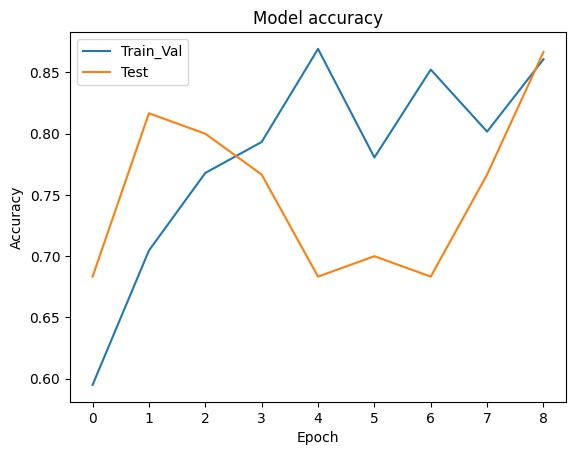

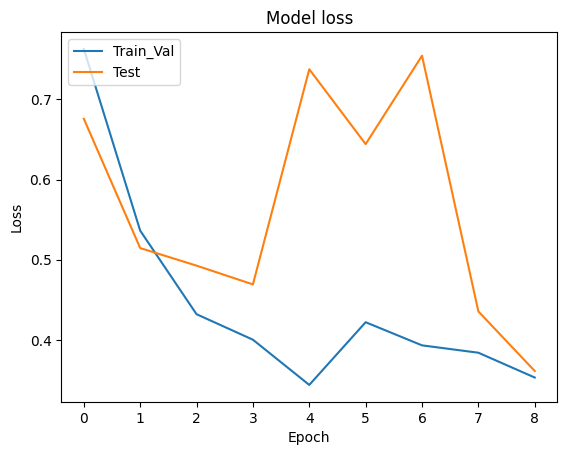

In [ ]:
# Plot training and validation accuracy curves
plt.plot(EfficientNetV2B0_history.history['accuracy'])
plt.plot(EfficientNetV2B0_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_Val', 'Test'], loc='upper left')
plt.show()

# Plot training and validation loss curves
plt.plot(EfficientNetV2B0_history.history['loss'])
plt.plot(EfficientNetV2B0_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_Val', 'Test'], loc='upper left')
plt.show()

## Test the performance of the EfficientNetV2B0 model on the test set.

In [ ]:
# Evaluate model performance on test set
performance_EfficientNetV2B0 = model.evaluate(test)
print('Test loss:', performance_EfficientNetV2B0[0])
print('Test accuracy:', performance_EfficientNetV2B0[1])

2/2 [==============================] - 11s 5s/step - loss: 0.3611 - accuracy: 0.8667 - recall: 0.9048 - precision: 0.9048
Test loss: 0.3610677719116211
Test accuracy: 0.8666666746139526


In [ ]:
# Use the trained model to predict on the test set and round the prediction
y_pred = model.predict(test)
y_pred = np.round(y_pred)

# Calculate the evaluation metrics
accuracy = accuracy_score(test.labels, y_pred)
precision = precision_score(test.labels, y_pred)
recall = recall_score(test.labels, y_pred)
f1score = f1_score(test.labels, y_pred)
f1score_macro = f1_score(test.labels, y_pred, average = 'macro')
auc_roc = roc_auc_score(test.labels, y_pred)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(test.labels, y_pred))

2/2 [==============================] - 13s 5s/step
Accuracy: 0.8666666666666667
Precision: 0.9047619047619048
Recall: 0.9047619047619048
F1-score: 0.9047619047619048
F1_score_macro: 0.8412698412698413
AUC-ROC: 0.8412698412698412

              precision    recall  f1-score   support

           0       0.78      0.78      0.78        18
           1       0.90      0.90      0.90        42

    accuracy                           0.87        60
   macro avg       0.84      0.84      0.84        60
weighted avg       0.87      0.87      0.87        60



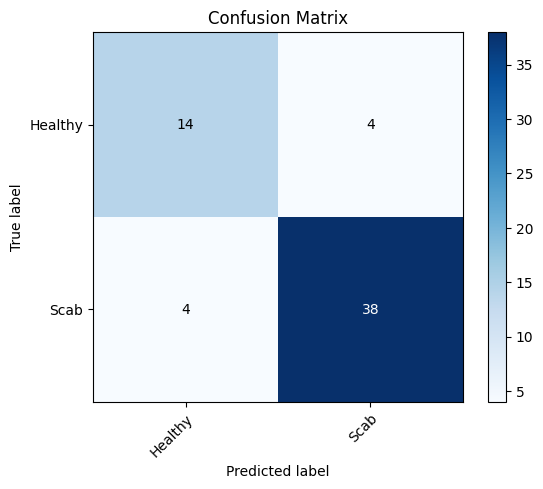

In [ ]:
# Create a confusion matrix:
cm = confusion_matrix(test.labels, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title
ax.set_title("Confusion Matrix")

# Show the plot
plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()

# ConvNeXtTiny model:

## Perform hyperparameter tuning on the ConvNeXtTiny: model.

In [ ]:
def hp_fruits_ConvNeXtTiny(trail):

  clear_session()

  # preprocess data
  train, val, train_val, test = train_val_test_generators(train_dir, val_dir, train_val_dir, test_dir)

  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train.classes), y = train.classes)
  class_weights = {i : class_weights[i] for i in range(2)}

  # build model
  from tensorflow.keras.applications import ConvNeXtTiny
  from tensorflow.keras import layers

  ConvNeXtTiny_model = ConvNeXtTiny(input_shape = (224, 224, 3), 
                                  include_top = False, 
                                  weights = 'imagenet',
                                  include_preprocessing = False)

  for layer in ConvNeXtTiny_model.layers:
    layer.trainable = False

  last_output = ConvNeXtTiny_model.output
  x = layers.Flatten()(last_output)
  
  hidden_layers = trail.suggest_int('hidden_layers', 1, 2)

  for i in range(hidden_layers):
    first_neuron = trail.suggest_categorical('first_neuron', [128, 256, 512])
    x = layers.Dense(first_neuron, activation='relu')(x)
    drop_out = trail.suggest_categorical('drop_out', [0, 0.3, 0.5])
    x = layers.Dropout(drop_out)(x)                  
  
  x = layers.Dense(1, activation='sigmoid')(x)           

  model = Model(ConvNeXtTiny_model.input, x)

  # compile/train model
  optimizer_name = trail.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'AdamW'])
  learning_rate = trail.suggest_float('lr', 1e-5, 1e-2, log=True)

  if optimizer_name == 'Adam':
      optimizer = Adam(learning_rate=learning_rate)
  elif optimizer_name == 'RMSprop':
      optimizer = RMSprop(learning_rate=learning_rate)
  elif optimizer_name == 'AdamW':
      optimizer = AdamW(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,
                loss = 'binary_crossentropy', 
                metrics = ['accuracy', Recall(), Precision()])
  
  early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
  
  model.fit(train, validation_data=val, class_weight=class_weights, epochs = 100, callbacks=[early_stop],
            max_queue_size=40, workers=4, use_multiprocessing=True)
  
  # Evaluate macro f1 score
  y_pred_val = model.predict(val)
  y_pred_val = np.round(y_pred_val)

  f1score_macro = f1_score(val.labels, y_pred_val, average = 'macro')
  print(f1score_macro)
  
  return f1score_macro

if __name__ == "__main__":
    warnings.warn(
        "Recent Keras release (2.4.0) simply redirects all APIs "
        "in the standalone keras package to point to tf.keras. "
        "There is now only one Keras: tf.keras. "
        "There may be some breaking changes for some workflows by upgrading to keras 2.4.0. "
        "Test before upgrading. "
        "REF:https://github.com/keras-team/keras/releases/tag/2.4.0"
    )
    study = optuna.create_study(direction="maximize")
    study.optimize(hp_fruits_ConvNeXtTiny, n_trials=10)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

<ipython-input-11-e0b0dcbfd6f3>:68: UserWarning: Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  warnings.warn(
[I 2023-05-15 12:15:08,476] A new study created in memory with name: no-name-2325c054-92aa-4220-9f73-86db9ccfe6ec


Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 88s 12s/step - loss: 2.7591 - accuracy: 0.5337 - recall: 0.5565 - precision: 0.7113 - val_loss: 0.7292 - val_accuracy: 0.6610 - val_recall: 0.7073 - val_precision: 0.7838
Epoch 2/100
6/6 [==============================] - 29s 4s/step - loss: 2.6954 - accuracy: 0.5899 - recall: 0.5968 - precision: 0.7629 - val_loss: 2.9252 - val_accuracy: 0.3729 - val_recall: 0.1220 - val_precision: 0.8333
Epoch 3/100
6/6 [==============================] - 29s 4s/step - loss: 2.8742 - accuracy: 0.4888 - recall: 0.4758 - precision: 0.6941 - val_loss: 0.9064 - val_accuracy: 0.6271 - val_recall: 0.6341 - val_precision: 0.7879
Epoch 4/100
6/6 [==============================] - 32s 4s/step - loss: 2.1577 - accuracy: 0.6236 - recall: 0.6774 - precision: 0.7568 - val_loss: 2.1653 - val_accuracy: 0.355

[I 2023-05-15 12:27:33,212] Trial 0 finished with value: 0.6547332185886403 and parameters: {'hidden_layers': 2, 'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 0.0008442042570071173}. Best is trial 0 with value: 0.6547332185886403.


0.6547332185886403
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 53s 7s/step - loss: 1.3595 - accuracy: 0.5449 - recall: 0.5887 - precision: 0.7087 - val_loss: 0.9081 - val_accuracy: 0.4407 - val_recall: 0.1951 - val_precision: 1.0000
Epoch 2/100
6/6 [==============================] - 29s 4s/step - loss: 1.4225 - accuracy: 0.5169 - recall: 0.4919 - precision: 0.7262 - val_loss: 0.8503 - val_accuracy: 0.5593 - val_recall: 0.4634 - val_precision: 0.8261
Epoch 3/100
6/6 [==============================] - 31s 4s/step - loss: 1.1722 - accuracy: 0.6292 - recall: 0.6935 - precision: 0.7544 - val_loss: 0.6475 - val_accuracy: 0.6949 - val_recall: 0.7073 - val_precision: 0.8286
Epoch 4/100
6/6 [==============================] - 29s 4s/step - loss: 0.8671 - accuracy: 0.6742 - recall: 0.6855 - precision: 0.8173 - val_loss: 0.6196 - v

[I 2023-05-15 12:34:50,622] Trial 1 finished with value: 0.6871212121212121 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 0.00024480195585166713}. Best is trial 1 with value: 0.6871212121212121.


0.6871212121212121
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 48s 6s/step - loss: 1.0911 - accuracy: 0.5449 - recall: 0.5645 - precision: 0.7216 - val_loss: 1.3482 - val_accuracy: 0.3051 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/100
6/6 [==============================] - 31s 5s/step - loss: 0.9059 - accuracy: 0.4888 - recall: 0.4194 - precision: 0.7324 - val_loss: 0.5660 - val_accuracy: 0.7119 - val_recall: 0.9756 - val_precision: 0.7143
Epoch 3/100
6/6 [==============================] - 31s 4s/step - loss: 0.7403 - accuracy: 0.6404 - recall: 0.7339 - precision: 0.7459 - val_loss: 0.6099 - val_accuracy: 0.7458 - val_recall: 0.7805 - val_precision: 0.8421
Epoch 4/100
6/6 [==============================] - 30s 4s/step - loss: 0.7128 - accuracy: 0.5730 - recall: 0.5403 - precision: 0.7791 - val_loss: 0.

[I 2023-05-15 12:39:41,710] Trial 2 finished with value: 0.5076092292587138 and parameters: {'hidden_layers': 2, 'first_neuron': 128, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.00025567877172680563}. Best is trial 1 with value: 0.6871212121212121.


0.5076092292587138
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 50s 7s/step - loss: 1.4078 - accuracy: 0.5730 - recall: 0.6371 - precision: 0.7182 - val_loss: 0.8977 - val_accuracy: 0.4746 - val_recall: 0.3171 - val_precision: 0.8125
Epoch 2/100
6/6 [==============================] - 30s 5s/step - loss: 0.7863 - accuracy: 0.5674 - recall: 0.5081 - precision: 0.7975 - val_loss: 0.5158 - val_accuracy: 0.7797 - val_recall: 0.9756 - val_precision: 0.7692
Epoch 3/100
6/6 [==============================] - 30s 4s/step - loss: 0.6272 - accuracy: 0.6742 - recall: 0.6452 - precision: 0.8511 - val_loss: 0.5225 - val_accuracy: 0.7966 - val_recall: 0.8780 - val_precision: 0.8372
Epoch 4/100
6/6 [==============================] - 29s 4s/step - loss: 0.4933 - accuracy: 0.8090 - recall: 0.8790 - precision: 0.8516 - val_loss: 0.7401 - v

2/2 [==============================] - 12s 5s/step


[I 2023-05-15 12:54:58,738] Trial 3 finished with value: 0.8527629233511586 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 0.00026577539043344924}. Best is trial 3 with value: 0.8527629233511586.


0.8527629233511586
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 49s 6s/step - loss: 11.3052 - accuracy: 0.5056 - recall: 0.5806 - precision: 0.6667 - val_loss: 9.0507 - val_accuracy: 0.3051 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/100
6/6 [==============================] - 30s 5s/step - loss: 4.7035 - accuracy: 0.5393 - recall: 0.5161 - precision: 0.7442 - val_loss: 1.1430 - val_accuracy: 0.4746 - val_recall: 0.3171 - val_precision: 0.8125
Epoch 3/100
6/6 [==============================] - 30s 4s/step - loss: 2.9157 - accuracy: 0.5506 - recall: 0.5484 - precision: 0.7391 - val_loss: 2.0263 - val_accuracy: 0.3390 - val_recall: 0.0488 - val_precision: 1.0000
Epoch 4/100
6/6 [==============================] - 31s 4s/step - loss: 1.5944 - accuracy: 0.6461 - recall: 0.6371 - precision: 0.8144 - val_loss: 2

2/2 [==============================] - 12s 5s/step


[I 2023-05-15 13:06:35,692] Trial 4 finished with value: 0.5178494623655914 and parameters: {'hidden_layers': 2, 'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 0.001144568805083578}. Best is trial 3 with value: 0.8527629233511586.


0.5178494623655914
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 53s 7s/step - loss: 1.0200 - accuracy: 0.5899 - recall: 0.5968 - precision: 0.7629 - val_loss: 0.6123 - val_accuracy: 0.7627 - val_recall: 0.9512 - val_precision: 0.7647
Epoch 2/100
6/6 [==============================] - 29s 4s/step - loss: 0.8299 - accuracy: 0.5337 - recall: 0.4839 - precision: 0.7595 - val_loss: 1.1236 - val_accuracy: 0.4407 - val_recall: 0.2195 - val_precision: 0.9000
Epoch 3/100
6/6 [==============================] - 31s 5s/step - loss: 0.6449 - accuracy: 0.7191 - recall: 0.7903 - precision: 0.8033 - val_loss: 0.5614 - val_accuracy: 0.6949 - val_recall: 0.7561 - val_precision: 0.7949
Epoch 4/100
6/6 [==============================] - 32s 5s/step - loss: 0.6514 - accuracy: 0.6629 - recall: 0.6613 - precision: 0.8200 - val_loss: 1.1600 - v

[I 2023-05-15 13:15:15,524] Trial 5 finished with value: 0.7987596899224807 and parameters: {'hidden_layers': 1, 'first_neuron': 256, 'drop_out': 0.3, 'optimizer': 'AdamW', 'lr': 6.200987641590972e-05}. Best is trial 3 with value: 0.8527629233511586.


0.7987596899224807
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 48s 6s/step - loss: 0.9270 - accuracy: 0.3989 - recall: 0.3306 - precision: 0.6308 - val_loss: 0.8478 - val_accuracy: 0.2881 - val_recall: 0.0732 - val_precision: 0.4286
Epoch 2/100
6/6 [==============================] - 30s 5s/step - loss: 0.6569 - accuracy: 0.7079 - recall: 0.7661 - precision: 0.8051 - val_loss: 0.6175 - val_accuracy: 0.7288 - val_recall: 0.9268 - val_precision: 0.7451
Epoch 3/100
6/6 [==============================] - 29s 4s/step - loss: 0.6062 - accuracy: 0.7303 - recall: 0.7581 - precision: 0.8393 - val_loss: 0.7595 - val_accuracy: 0.4746 - val_recall: 0.3415 - val_precision: 0.7778
Epoch 4/100
6/6 [==============================] - 31s 4s/step - loss: 0.5173 - accuracy: 0.7416 - recall: 0.7500 - precision: 0.8611 - val_loss: 0.5361 - v

[I 2023-05-15 13:31:05,614] Trial 6 finished with value: 0.8228228228228228 and parameters: {'hidden_layers': 2, 'first_neuron': 128, 'drop_out': 0, 'optimizer': 'Adam', 'lr': 0.00017785507246392867}. Best is trial 3 with value: 0.8527629233511586.


0.8228228228228228
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 50s 7s/step - loss: 41.9902 - accuracy: 0.5562 - recall: 0.6210 - precision: 0.7064 - val_loss: 0.6650 - val_accuracy: 0.6441 - val_recall: 0.7073 - val_precision: 0.7632
Epoch 2/100
6/6 [==============================] - 29s 4s/step - loss: 2.8538 - accuracy: 0.5393 - recall: 0.5242 - precision: 0.7386 - val_loss: 2.1601 - val_accuracy: 0.6949 - val_recall: 1.0000 - val_precision: 0.6949
Epoch 3/100
6/6 [==============================] - 30s 4s/step - loss: 1.7361 - accuracy: 0.5112 - recall: 0.4758 - precision: 0.7284 - val_loss: 0.6668 - val_accuracy: 0.7458 - val_recall: 1.0000 - val_precision: 0.7321
Epoch 4/100
6/6 [==============================] - 32s 5s/step - loss: 1.5951 - accuracy: 0.5899 - recall: 0.6452 - precision: 0.7339 - val_loss: 3.3241 - 

[I 2023-05-15 13:35:25,755] Trial 7 finished with value: 0.5978578383641674 and parameters: {'hidden_layers': 2, 'first_neuron': 256, 'drop_out': 0, 'optimizer': 'RMSprop', 'lr': 0.0026235563000282635}. Best is trial 3 with value: 0.8527629233511586.


0.5978578383641674
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 50s 6s/step - loss: 12.1643 - accuracy: 0.4551 - recall: 0.4839 - precision: 0.6452 - val_loss: 1.7803 - val_accuracy: 0.6949 - val_recall: 1.0000 - val_precision: 0.6949
Epoch 2/100
6/6 [==============================] - 30s 4s/step - loss: 2.2862 - accuracy: 0.5955 - recall: 0.6694 - precision: 0.7281 - val_loss: 3.7369 - val_accuracy: 0.3051 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/100
6/6 [==============================] - 31s 5s/step - loss: 1.3200 - accuracy: 0.6461 - recall: 0.6048 - precision: 0.8427 - val_loss: 0.5396 - val_accuracy: 0.7797 - val_recall: 0.9024 - val_precision: 0.8043
Epoch 4/100
6/6 [==============================] - 31s 4s/step - loss: 1.0602 - accuracy: 0.7416 - recall: 0.7500 - precision: 0.8611 - val_loss: 0

[I 2023-05-15 13:52:23,967] Trial 8 finished with value: 0.7440774107440773 and parameters: {'hidden_layers': 1, 'first_neuron': 512, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 0.0004456516106634567}. Best is trial 3 with value: 0.8527629233511586.


0.7440774107440773
Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/100
6/6 [==============================] - 53s 7s/step - loss: 0.9062 - accuracy: 0.4888 - recall: 0.5161 - precision: 0.6737 - val_loss: 0.7524 - val_accuracy: 0.4915 - val_recall: 0.4878 - val_precision: 0.6897
Epoch 2/100
6/6 [==============================] - 29s 4s/step - loss: 0.7498 - accuracy: 0.5787 - recall: 0.5403 - precision: 0.7882 - val_loss: 0.7533 - val_accuracy: 0.5085 - val_recall: 0.4878 - val_precision: 0.7143
Epoch 3/100
6/6 [==============================] - 30s 4s/step - loss: 0.7537 - accuracy: 0.5899 - recall: 0.6210 - precision: 0.7476 - val_loss: 0.6752 - val_accuracy: 0.5932 - val_recall: 0.6341 - val_precision: 0.7429
Epoch 4/100
6/6 [==============================] - 31s 5s/step - loss: 0.6167 - accuracy: 0.6461 - recall: 0.6371 - precision: 0.8144 - val_loss: 0.6803 - v

[I 2023-05-15 14:15:57,635] Trial 9 finished with value: 0.8347338935574229 and parameters: {'hidden_layers': 1, 'first_neuron': 512, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 1.6763484662757232e-05}. Best is trial 3 with value: 0.8527629233511586.


0.8347338935574229
Number of finished trials: 10
Best trial:
  Value: 0.8527629233511586
  Params: 
    hidden_layers: 2
    first_neuron: 512
    drop_out: 0
    optimizer: AdamW
    lr: 0.00026577539043344924


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_hidden_layers,params_lr,params_optimizer,state
0,0,0.654733,2023-05-15 12:15:08.479206,2023-05-15 12:27:33.211809,0 days 00:12:24.732603,0.5,256,2,0.000844,Adam,COMPLETE
1,1,0.687121,2023-05-15 12:27:33.213910,2023-05-15 12:34:50.621872,0 days 00:07:17.407962,0.5,512,2,0.000245,Adam,COMPLETE
2,2,0.507609,2023-05-15 12:34:50.623586,2023-05-15 12:39:41.709419,0 days 00:04:51.085833,0.3,128,2,0.000256,Adam,COMPLETE
3,3,0.852763,2023-05-15 12:39:41.711549,2023-05-15 12:54:58.737954,0 days 00:15:17.026405,0.0,512,2,0.000266,AdamW,COMPLETE
4,4,0.517849,2023-05-15 12:54:58.740054,2023-05-15 13:06:35.691376,0 days 00:11:36.951322,0.5,256,2,0.001145,RMSprop,COMPLETE
5,5,0.798760,2023-05-15 13:06:35.693468,2023-05-15 13:15:15.524127,0 days 00:08:39.830659,0.3,256,1,0.000062,AdamW,COMPLETE
6,6,0.822823,2023-05-15 13:15:15.526453,2023-05-15 13:31:05.613642,0 days 00:15:50.087189,0.0,128,2,0.000178,Adam,COMPLETE
7,7,0.597858,2023-05-15 13:31:05.616349,2023-05-15 13:35:25.754863,0 days 00:04:20.138514,0.0,256,2,0.002624,RMSprop,COMPLETE
8,8,0.744077,2023-05-15 13:35:25.757306,2023-05-15 13:52:23.966701,0 days 00:16:58.209395,0.5,512,1,0.000446,RMSprop,COMPLETE
9,9,0.834734,2023-05-15 13:52:23.969651,2023-05-15 14:15:57.634780,0 days 00:23:33.665129,0.3,512,1,0.000017,Adam,COMPLETE


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

## Re-train the ConvNeXtTiny model using the best hyperparameters.

In [ ]:
clear_session()

from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras import layers

# preprocess data
train, val, train_val, test = train_val_test_generators(train_dir, val_dir, train_val_dir, test_dir)

class_weights_train_val = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_val.classes), y = train_val.classes)
class_weights_train_val = {i : class_weights_train_val[i] for i in range(2)}

# get best hyperparameters
best_hidden_layers = study.best_params['hidden_layers']
best_neurons = study.best_params['first_neuron']
best_dropout = study.best_params['drop_out']
best_optimizer = study.best_params['optimizer']
best_lr = study.best_params['lr']
epochs = 18 # take best epoch from HP tuning trail


ConvNeXtTiny_model = ConvNeXtTiny(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = 'imagenet',
                                include_preprocessing = False)

for layer in ConvNeXtTiny_model.layers:
  layer.trainable = False

last_output = ConvNeXtTiny_model.output
x = layers.Flatten()(last_output)

for i in range(best_hidden_layers):
  x = layers.Dense(best_neurons, activation='relu')(x)
  x = layers.Dropout(best_dropout)(x)                  

x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(ConvNeXtTiny_model.input, x) 

if best_optimizer == 'Adam':
    optimizer = Adam(learning_rate=best_lr)
elif best_optimizer == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_lr)
elif best_optimizer == 'AdamW':
    optimizer = AdamW(learning_rate=best_lr)


model.compile(optimizer=optimizer,
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', Recall(), Precision()])

ConvNeXtTiny_history = model.fit(train_val, validation_data=test, # test set used only for monitoring loss and accuracy, not for HP tuning
                                 class_weight=class_weights_train_val, epochs = epochs,
                                 max_queue_size=40, workers=4, use_multiprocessing=True)

Found 178 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/18
8/8 [==============================] - 58s 5s/step - loss: 1.6386 - accuracy: 0.5485 - recall: 0.5818 - precision: 0.7164 - val_loss: 1.3901 - val_accuracy: 0.3500 - val_recall: 0.0714 - val_precision: 1.0000
Epoch 2/18
8/8 [==============================] - 32s 3s/step - loss: 0.6319 - accuracy: 0.5907 - recall: 0.5273 - precision: 0.8208 - val_loss: 0.5324 - val_accuracy: 0.6667 - val_recall: 0.5952 - val_precision: 0.8929
Epoch 3/18
8/8 [==============================] - 32s 4s/step - loss: 0.6137 - accuracy: 0.6540 - recall: 0.6667 - precision: 0.8029 - val_loss: 0.4185 - val_accuracy: 0.8500 - val_recall: 0.9048 - val_precision: 0.8837
Epoch 4/18
8/8 [==============================] - 32s 3s/step - loss: 0.4854 - accuracy: 0.7595 - recall: 0.7758 - precision: 0.8649 - val_loss: 0.3841 - val_accuracy: 0.8333 - v

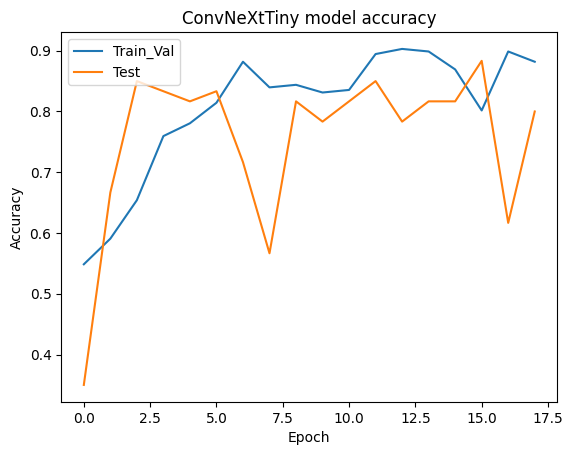

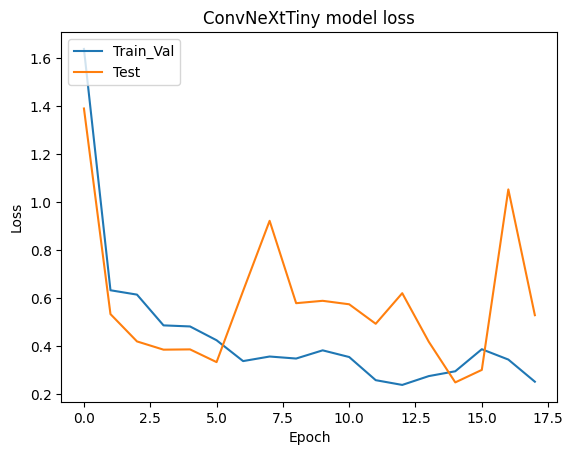

In [ ]:
# Plot training and validation accuracy curves
plt.plot(ConvNeXtTiny_history.history['accuracy'])
plt.plot(ConvNeXtTiny_history.history['val_accuracy'])
plt.title('ConvNeXtTiny model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_Val', 'Test'], loc='upper left')
plt.show()

# Plot training and validation loss curves
plt.plot(ConvNeXtTiny_history.history['loss'])
plt.plot(ConvNeXtTiny_history.history['val_loss'])
plt.title('ConvNeXtTiny model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_Val', 'Test'], loc='upper left')
plt.show()

## Test the performance of the ConvNeXtTiny model on the test set.

In [ ]:
# Evaluate model performance on test set
performance_ConvNeXtTiny = model.evaluate(test)
print('Test loss:', performance_ConvNeXtTiny[0])
print('Test accuracy:', performance_ConvNeXtTiny[1])

2/2 [==============================] - 11s 5s/step - loss: 0.5279 - accuracy: 0.8000 - recall: 0.7143 - precision: 1.0000
Test loss: 0.5278818607330322
Test accuracy: 0.800000011920929


In [ ]:
# Use the trained model to predict on the test set and round the prediction
y_pred = model.predict(test)
y_pred = np.round(y_pred)

# Calculate the evaluation metrics
accuracy = accuracy_score(test.labels, y_pred)
precision = precision_score(test.labels, y_pred)
recall = recall_score(test.labels, y_pred)
f1score = f1_score(test.labels, y_pred)
f1score_macro = f1_score(test.labels, y_pred, average = 'macro')
auc_roc = roc_auc_score(test.labels, y_pred)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(test.labels, y_pred))

2/2 [==============================] - 12s 5s/step
Accuracy: 0.8
Precision: 1.0
Recall: 0.7142857142857143
F1-score: 0.8333333333333333
F1_score_macro: 0.7916666666666665
AUC-ROC: 0.8571428571428572

              precision    recall  f1-score   support

           0       0.60      1.00      0.75        18
           1       1.00      0.71      0.83        42

    accuracy                           0.80        60
   macro avg       0.80      0.86      0.79        60
weighted avg       0.88      0.80      0.81        60



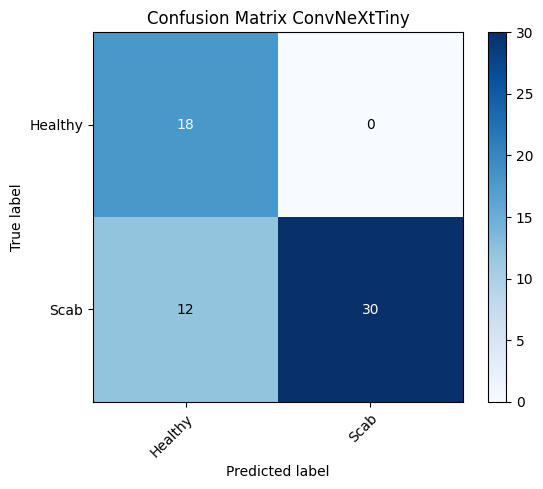

In [ ]:
# Create a confusion matrix:
cm = confusion_matrix(test.labels, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix ConvNeXtTiny")
plt.show()